## Machine Learning with Python


### Template to build a machine learning model with Python
1. This template contains detailed steps to preprocess raw data and convert it into model input
2. This template uses Random Forest, Gradient Boosting Machine, and lightGBM algorithms

### Steps to build a model:
1. Load the libaries and data
2. Data preprocessing  
    i. Remove variables with high missing values percentage  
    ii. Remove categorical variables with many levels  
    iii. Convert categorical variables to binary variables  
    iv. Split train and out of time samples  
    v. Impute missing values  
    vi. Remove variables based on Gini threshold  
3. Train the model (currently supporting scikit-learn RF, scikit-learn GBM, H2O RF, lightGBM)  
    i. Background feature selection  
    ii. Grid search for hyperparameter optimization using the following methods: 
        a. iterative steps
        b. search through fixed grid space
        c. search through random grid space
    iii. Train machine learning model   
    iv. Calculate feature importance  
4. Evaluate model  
    i. Calculate Gini  
    ii. Calculate lifting table \
    iii. Plot Detection rate vs. Quantile

### Machine Learning Libaries:
1. preprocessing
2. feature_selection
3. model_builder
4. evaluation


In [69]:
# Make the notebook full screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Initialize variables

In [70]:
# Set path that contains the macros
macros_path = '..\\functions'
# Set the path that contains the tables relevant to this code
input_data_path = r'..\..\data'
# Set the target variable name in the original dataset
target_variable_name = 'bad_flag'
# Set the weight variable name in the original dataset
weight_variable_name = 'weight'
# Set the (fraud) amount variable name in the original dataset
amount_variable_name = 'amount'
# Set the ID variable name in the original dataset
ID_variable_name = 'transact_id'

# Load the libaries and data

In [71]:
# Set the path for our library
import sys
sys.path.insert(0, macros_path)

In [72]:
# Load developed libraries
import preprocessing as pp
import model_builder as mb
import evaluation as ev
import feature_selection as fs
import keras_functions as ks_fn

import pandas as pd
import numpy as np
import importlib

importlib.reload(pp)
importlib.reload(mb)
importlib.reload(ev)
importlib.reload(fs)
importlib.reload(ks_fn)

<module 'keras_functions' from '..\\functions\\keras_functions.py'>

In [73]:
# load training data
data_path = '{}/input/Original_table.csv'.format(input_data_path)
data = pd.read_csv(data_path, sep=',')
data[amount_variable_name] = [0 if x ==0 else np.random.normal(loc=10000, scale=2000, size=None) for x in data[target_variable_name]] 
#data[weight_variable_name] = 1

In [74]:
################################## OPTIONAL STEP ############################################################################################
# Sample down the goods to speed up the algorithms
#data = pp.target_stratified_sampling(df=data, target_variable=target_variable_name, weight_variable=weight_variable_name, good_bad_ratio=1)
#############################################################################################################################################

In [75]:
# Show the first 5 lines of data
data.head()

,bad_flag,transact_id,weight,numeric1,numeric2,numeric3,numeric4,numeric5,character1,character2,character3,character4,character5,numeric6,numeric7,character6,character7,numeric8,character8,amount
0,1,1,0.736712,187.623961,78.0,NaN,4.430599,5.0,2,3.0,76.0,NaN,Y,894.657365,515,15,59,902.897122,63,9205.463352
1,0,2,3.684028,187.264058,11.0,NaN,6.939674,5.0,2,1.0,NaN,NaN,Y,915.539596,578,5,67,917.951881,68,0.000000
2,0,3,0.851397,122.329387,11.0,NaN,6.080552,5.0,3,2.0,87.0,NaN,Y,1279.135540,606,8,74,1280.035194,78,0.000000
3,0,4,2.021843,46.975890,113.0,NaN,1.343171,5.0,2,0.0,16.0,NaN,Y,800.633445,632,10,62,802.599883,65,0.000000
4,1,5,1.596753,145.971958,12.0,NaN,4.131622,5.0,5,1.0,102.0,NaN,Y,1026.813419,501,12,48,1037.083399,48,9223.221171


In [76]:
# Check the data type of all the fields
data.dtypes

bad_flag         int64
transact_id      int64
weight         float64
numeric1       float64
numeric2       float64
numeric3       float64
numeric4       float64
numeric5       float64
character1       int64
character2     float64
character3     float64
character4      object
character5      object
numeric6       float64
numeric7         int64
character6       int64
character7       int64
numeric8       float64
character8       int64
amount         float64
dtype: object

In [77]:
# Convert the character fields to strings
data[["character1", "character2", "character3", "character4", "character5", "character6", "character7", "character8"]] = data[["character1", "character2", "character3", "character4", "character5", "character6", "character7", "character8"]].astype(str).replace('nan',np.nan)
data.dtypes

bad_flag         int64
transact_id      int64
weight         float64
numeric1       float64
numeric2       float64
numeric3       float64
numeric4       float64
numeric5       float64
character1      object
character2      object
character3      object
character4      object
character5      object
numeric6       float64
numeric7         int64
character6      object
character7      object
numeric8       float64
character8      object
amount         float64
dtype: object

In [78]:
data.head()

,bad_flag,transact_id,weight,numeric1,numeric2,numeric3,numeric4,numeric5,character1,character2,character3,character4,character5,numeric6,numeric7,character6,character7,numeric8,character8,amount
0,1,1,0.736712,187.623961,78.0,NaN,4.430599,5.0,2,3.0,76.0,NaN,Y,894.657365,515,15,59,902.897122,63,9205.463352
1,0,2,3.684028,187.264058,11.0,NaN,6.939674,5.0,2,1.0,NaN,NaN,Y,915.539596,578,5,67,917.951881,68,0.000000
2,0,3,0.851397,122.329387,11.0,NaN,6.080552,5.0,3,2.0,87.0,NaN,Y,1279.135540,606,8,74,1280.035194,78,0.000000
3,0,4,2.021843,46.975890,113.0,NaN,1.343171,5.0,2,0.0,16.0,NaN,Y,800.633445,632,10,62,802.599883,65,0.000000
4,1,5,1.596753,145.971958,12.0,NaN,4.131622,5.0,5,1.0,102.0,NaN,Y,1026.813419,501,12,48,1037.083399,48,9223.221171


# Remove variables with high missing values percentage

In [79]:
# Check missing value percentage
data.apply(lambda x: sum(data[x.isnull()][weight_variable_name])/sum(data[weight_variable_name])*100, axis=0).sort_values(ascending=False) # Returns the number of missing values with percentages

character4     99.188878
numeric3       98.873902
character3      5.565565
numeric2        1.868185
numeric5        1.177583
numeric1        1.031407
character2      0.972249
character1      0.000000
transact_id     0.000000
weight          0.000000
numeric4        0.000000
amount          0.000000
character8      0.000000
character5      0.000000
numeric6        0.000000
numeric7        0.000000
character6      0.000000
character7      0.000000
numeric8        0.000000
bad_flag        0.000000
dtype: float64

In [80]:
# Varibles excluded from the final features: keys, target varibles, and others
var_excluded = set([target_variable_name, ID_variable_name, weight_variable_name, amount_variable_name])
print("Varibles to be excluded:")
print(var_excluded)
print("")

# features with too many missing values
var_missing_too_many = pp.var_missing(df=data, weight_variable=weight_variable_name, threshold=0.95)
print("Varibles with too many missing values:")
print(var_missing_too_many)
print("")

var_excluded = var_excluded | set(var_missing_too_many)
print ("Varibles to remove: ")
print (var_excluded)

Varibles to be excluded:
{'transact_id', 'weight', 'bad_flag', 'amount'}

Varibles with too many missing values:
['numeric3', 'character4']

Varibles to remove: 
{'transact_id', 'bad_flag', 'character4', 'amount', 'weight', 'numeric3'}


In [81]:
cat_vars = pp.get_cat_vars(df=data)
keep_cat_vars = [x for x in cat_vars if x not in var_excluded]
print (keep_cat_vars)

['character1', 'character2', 'character3', 'character5', 'character6', 'character7', 'character8']


# Remove categorical variables with many levels

In [82]:
cats = pp.classify_cats(df=data, cat_var_list=keep_cat_vars, threshold=50)
print ("Category variables in 3 classes: ")
for k, v in cats.items():
    print(k, v)
    print("")

Category variables in 3 classes: 
single ['character5']

binary []

small ['character1', 'character2', 'character6']

large ['character3', 'character7', 'character8']



# Convert categorical variables to binary variables

In [83]:
# Keep the numeric variables before converting categorical variables to binary
original_num_vars = pp.get_num_vars(data)
original_num_vars = [x for x in original_num_vars if x not in var_excluded]

In [84]:
# Convert categorical vars to binary 
pp.cats_binary_num(data, cats['binary'])
pp.cats_small_num(data, cats['small'], drop='last')

In [86]:
num_vars = pp.get_num_vars(data)
keep_num_vars = [x for x in num_vars if x not in var_excluded]
keep_num_vars[1:10]

['numeric2',
 'numeric4',
 'numeric5',
 'numeric6',
 'numeric7',
 'numeric8',
 'character1_2',
 'character1_1',
 'character1_3']

# Split to train and out of time samples

In [18]:
dev, oos = pp.data_split(data, 0.7)

# Impute missing values

In [19]:
# Impute the dev and oos data
imputer = pp.Imputer(vars=keep_num_vars, strategy='median')
imputer.fit_weight(dev, weight_variable=weight_variable_name)
imputer.transform(dev)
imputer.transform(oos)

In [20]:
# Normalize the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(dev[original_num_vars])
dev[original_num_vars] = sc.transform(dev[original_num_vars])
oos[original_num_vars] = sc.transform(oos[original_num_vars])

In [21]:
# Check missing value percentage for the development sample
#pd.set_option('display.max_rows', 10) 
dev[keep_num_vars].apply(lambda x: sum(dev[x.isnull()][weight_variable_name])/sum(dev[weight_variable_name])*100 if x.name in keep_num_vars else x, axis=0).sort_values(ascending=False)[1:10] # Returns the number of missing values with percentages

character1_7      0.0
character2_6.0    0.0
character2_5.0    0.0
character2_0.0    0.0
character2_4.0    0.0
character2_3.0    0.0
character2_1.0    0.0
character2_2.0    0.0
character1_12     0.0
dtype: float64

In [22]:
# Check missing value percentage for the validation sample
oos[keep_num_vars].apply(lambda x: sum(oos[x.isnull()][weight_variable_name])/sum(oos[weight_variable_name])*100 if x.name in keep_num_vars else x, axis=0).sort_values(ascending=False)[1:10] # Returns the number of missing values with percentages

character1_7      0.0
character2_6.0    0.0
character2_5.0    0.0
character2_0.0    0.0
character2_4.0    0.0
character2_3.0    0.0
character2_1.0    0.0
character2_2.0    0.0
character1_12     0.0
dtype: float64

# Feature selection based on Gini threshold

In [23]:
# Produce Gini value for all the variables
pp.gini_values_weight(feats=keep_num_vars, input_data=dev, target_variable=target_variable_name, 
                      weight_variable=weight_variable_name, n_bands=100)

[('numeric7', 0.9974064290497737),
 ('numeric6', 0.649039825012804),
 ('numeric8', 0.6476804334335504),
 ('numeric4', 0.022523048908634435),
 ('numeric2', 0.014348101437785532),
 ('numeric1', 0.007895885604463082),
 ('character2_nan', 0.0058062346574991874),
 ('character1_6', 0.0007293777308394755),
 ('character2_1.0', 0.0006904011795703102),
 ('character6_5', 0.0006904011795703102),
 ('character6_13', 0.0006298174562273662),
 ('character6_9', 0.0005384152111713725),
 ('character2_7.0', 0.0005346389177065536),
 ('character6_3', 0.0005226950843938427),
 ('character6_23', 0.00041593241208781606),
 ('character6_17', 0.000394152977946316),
 ('character6_22', 0.00038848397701185533),
 ('character2_0.0', 0.00037890123140815746),
 ('character6_10', 0.00037890123140815746),
 ('character1_12', 0.00033491698409315873),
 ('character2_5.0', 0.0003103448695135347),
 ('character6_7', 0.0003103448695135347),
 ('character1_4', 0.0003083250171851404),
 ('character2_9.0', 0.0003014841527269052),
 ('char

In [24]:
# Select the top variables based on Gini threshold
keep_gini_vars = pp.gini_selection_weight(feats=keep_num_vars, input_data=dev, target_variable=target_variable_name, 
                      weight_variable=weight_variable_name, n_bands=100, gini_threshold=0.0001)
print(keep_gini_vars)

['numeric7', 'numeric6', 'numeric8', 'numeric4', 'numeric2', 'numeric1', 'character2_nan', 'character1_6', 'character2_1.0', 'character6_5', 'character6_13', 'character6_9', 'character2_7.0', 'character6_3', 'character6_23', 'character6_17', 'character6_22', 'character2_0.0', 'character6_10', 'character1_12', 'character2_5.0', 'character6_7', 'character1_4', 'character2_9.0', 'character1_5', 'character6_12', 'character1_9', 'character6_19', 'character1_8', 'character2_11.0', 'character1_0', 'character2_6.0', 'character6_11', 'character6_16', 'character6_4', 'character6_18', 'character1_10', 'character6_2', 'character1_3', 'character2_2.0', 'character6_8', 'character1_2', 'character2_3.0', 'character6_15', 'character6_24', 'character2_10.0', 'character1_11', 'character6_1', 'character1_7', 'character1_1', 'character2_4.0', 'character6_6']


# Feature Selection

In [25]:
# Provide input data to feature selection class
select = fs.SelectBest_weight(df=dev, target=target_variable_name, weight=weight_variable_name)

## Feature selection based on Gini

In [26]:
# Select the top features
gini_importance, feats_best_gini = select.best_univar_gini(feats=keep_gini_vars, n=20)
print('The top Gini features are: \n', feats_best_gini)
gini_importance

The top Gini features are: 
 ['numeric7', 'numeric6', 'numeric8', 'numeric4', 'numeric2', 'numeric1', 'character2_nan', 'character1_6', 'character2_1.0', 'character6_5', 'character6_13', 'character6_9', 'character2_7.0', 'character6_3', 'character6_23', 'character6_17', 'character6_22', 'character2_0.0', 'character6_10', 'character1_12']


[('numeric7', 0.9974064290497737),
 ('numeric6', 0.649039825012804),
 ('numeric8', 0.6476804334335504),
 ('numeric4', 0.022523048908634435),
 ('numeric2', 0.014348101437785532),
 ('numeric1', 0.007895885604463082),
 ('character2_nan', 0.0058062346574991874),
 ('character1_6', 0.0007293777308394755),
 ('character2_1.0', 0.0006904011795703102),
 ('character6_5', 0.0006904011795703102),
 ('character6_13', 0.0006298174562273662),
 ('character6_9', 0.0005384152111713725),
 ('character2_7.0', 0.0005346389177065536),
 ('character6_3', 0.0005226950843938427),
 ('character6_23', 0.00041593241208781606),
 ('character6_17', 0.000394152977946316),
 ('character6_22', 0.00038848397701185533),
 ('character2_0.0', 0.00037890123140815746),
 ('character6_10', 0.00037890123140815746),
 ('character1_12', 0.00033491698409315873),
 ('character2_5.0', 0.0003103448695135347),
 ('character6_7', 0.0003103448695135347),
 ('character1_4', 0.0003083250171851404),
 ('character2_9.0', 0.0003014841527269052),
 ('char

## Feature selection based on Support Vector Machines

In [27]:
# Select the top features
from sklearn.svm import LinearSVC
model_svm = LinearSVC(C=0.01, penalty="l2", dual=False,random_state=42, max_iter=10000)
svm_importance, feats_best_svm = select.top_svc_feat(feats=keep_gini_vars, model=model_svm, n=30)
print('The top SVM features are: \n', feats_best_svm)
print('Sorted SVM feature importance: \n')
svm_importance

The top SVM features are: 
 ['numeric7', 'numeric6', 'numeric8', 'character2_nan', 'numeric2', 'numeric1', 'character2_9.0', 'numeric4', 'character2_1.0', 'character6_5', 'character1_6', 'character1_3', 'character2_2.0', 'character6_8', 'character1_2', 'character2_3.0', 'character6_15', 'character6_9', 'character6_23', 'character1_7', 'character6_24', 'character6_13', 'character6_3', 'character1_12', 'character2_7.0', 'character1_5', 'character6_12', 'character2_0.0', 'character6_10', 'character1_0']
Sorted SVM feature importance: 



[('numeric7', -1.84760993531412),
 ('numeric6', 0.20225505562643872),
 ('numeric8', 0.1684053882606405),
 ('character2_nan', 0.08098560874696527),
 ('numeric2', 0.04239006252344907),
 ('numeric1', 0.03822376328719522),
 ('character2_9.0', -0.010750106472603363),
 ('numeric4', -0.009311562777997497),
 ('character2_1.0', -0.0005665082642457332),
 ('character6_5', -0.0005665082642457332),
 ('character1_6', 0.0005131348417892218),
 ('character1_3', -8.138614489858957e-05),
 ('character2_2.0', -8.138614489858957e-05),
 ('character6_8', -8.138614489858957e-05),
 ('character1_2', 7.94198736915481e-05),
 ('character2_3.0', 7.94198736915481e-05),
 ('character6_15', 7.94198736915481e-05),
 ('character6_9', 5.830338824852502e-05),
 ('character6_23', 5.5186567474671566e-05),
 ('character1_7', -4.6707519114921105e-05),
 ('character6_24', 3.2242382308939234e-05),
 ('character6_13', 3.0445117183684452e-05),
 ('character6_3', 2.4449336192125512e-05),
 ('character1_12', 2.2280809540759796e-05),
 ('char

In [28]:
# Further reduction using backward selection
import timeit
start = timeit.default_timer()

# Backward selection with support vector machine model: In each step a feature is selected to remove - this removal maximizes Gini
from sklearn.calibration import CalibratedClassifierCV
model_svm_back = CalibratedClassifierCV(LinearSVC(C=0.01, penalty="l2", dual=False,random_state=42, max_iter=10000))
feats_best_svm_back = select.backward_recur(feats=feats_best_svm, oos=oos, model=model_svm_back, min_feats=20, classification=True)
print(feats_best_svm_back)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
# Execution time in seconds:  18.693381

step i = 1 feature removed: numeric8 gini: 0.9985321336639126
step i = 2 feature removed: numeric2 gini: 0.9985442762383607
step i = 3 feature removed: numeric1 gini: 0.9985759028852508
step i = 4 feature removed: character2_nan gini: 0.9985792657728241
step i = 5 feature removed: character2_1.0 gini: 0.9985792657728241
step i = 6 feature removed: character1_6 gini: 0.9985792657728241
step i = 7 feature removed: character1_3 gini: 0.9985792657728241
step i = 8 feature removed: character2_2.0 gini: 0.9985792657728241
step i = 9 feature removed: character6_8 gini: 0.9985792657728241
step i = 10 feature removed: character1_2 gini: 0.9985792657728241
['numeric7', 'numeric6', 'character2_9.0', 'numeric4', 'character6_5', 'character2_3.0', 'character6_15', 'character6_9', 'character6_23', 'character1_7', 'character6_24', 'character6_13', 'character6_3', 'character1_12', 'character2_7.0', 'character1_5', 'character6_12', 'character2_0.0', 'character6_10', 'character1_0']
Execution time in sec

## Feature selection based on Logistic Regression

In [29]:
# Select the top features
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(C=0.01, penalty="l2",random_state=42, max_iter=1000, solver='lbfgs')
lr_importance, feats_best_lr = select.top_lr_feat(feats=keep_gini_vars, model=model_lr, n=30)
print('The top LR features are: \n', feats_best_lr)
print('Sorted LR feature importance: \n')
lr_importance

The top LR features are: 
 ['numeric7', 'numeric6', 'numeric8', 'character2_nan', 'numeric1', 'numeric2', 'numeric4', 'character1_6', 'character2_1.0', 'character6_5', 'character2_9.0', 'character6_9', 'character1_3', 'character2_2.0', 'character6_8', 'character6_23', 'character1_2', 'character2_3.0', 'character6_15', 'character6_3', 'character6_24', 'character2_5.0', 'character6_7', 'character1_0', 'character2_6.0', 'character6_11', 'character2_7.0', 'character1_5', 'character6_12', 'character1_7']
Sorted LR feature importance: 



[('numeric7', -3.327113022407946),
 ('numeric6', 0.5086302971915306),
 ('numeric8', 0.49287095102492423),
 ('character2_nan', 0.04320932476989877),
 ('numeric1', 0.033314626732351145),
 ('numeric2', 0.028497785582364377),
 ('numeric4', -0.02321898539647694),
 ('character1_6', 0.004986932238008861),
 ('character2_1.0', -0.004830784781559867),
 ('character6_5', -0.004830784781559867),
 ('character2_9.0', -0.00381081003608973),
 ('character6_9', 0.0016001450197164467),
 ('character1_3', -0.0014597226597973423),
 ('character2_2.0', -0.0014597226597973423),
 ('character6_8', -0.0014597226597973423),
 ('character6_23', 0.001265927254701911),
 ('character1_2', 0.0009511845475850499),
 ('character2_3.0', 0.0009511845475850499),
 ('character6_15', 0.0009511845475850499),
 ('character6_3', -0.000648597320896374),
 ('character6_24', 0.0006051729110826307),
 ('character2_5.0', -0.0005560068272357928),
 ('character6_7', -0.0005560068272357928),
 ('character1_0', 0.0005485743153314961),
 ('character

In [30]:
# Further reduction using backward selection
import timeit
start = timeit.default_timer()

# Backward selection with logistic regression model: In each step a feature is selected to remove - this removal maximizes Gini
feats_best_lr_back = select.backward_recur(feats=feats_best_lr, oos=oos, model=model_lr, min_feats=20, classification=True)
print(feats_best_lr_back)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
# Execution time in seconds:  6.357881499999998

step i = 1 feature removed: numeric6 gini: 0.998367824849242
step i = 2 feature removed: numeric1 gini: 0.9983809411135298
step i = 3 feature removed: numeric2 gini: 0.9983919581685625
step i = 4 feature removed: character2_nan gini: 0.9983930418420965
step i = 5 feature removed: character1_6 gini: 0.9983930418420965
step i = 6 feature removed: character2_1.0 gini: 0.9983930418420965
step i = 7 feature removed: character6_5 gini: 0.9983930418420965
step i = 8 feature removed: character2_9.0 gini: 0.9983930418420965
step i = 9 feature removed: character6_9 gini: 0.9983930418420965
step i = 10 feature removed: character1_3 gini: 0.9983930418420965
['numeric7', 'numeric8', 'numeric4', 'character2_2.0', 'character6_8', 'character6_23', 'character1_2', 'character2_3.0', 'character6_15', 'character6_3', 'character6_24', 'character2_5.0', 'character6_7', 'character1_0', 'character2_6.0', 'character6_11', 'character2_7.0', 'character1_5', 'character6_12', 'character1_7']
Execution time in seco

# Random Forest

## Feature selection RF

In [31]:
# Provide input data to feature selection class
select = fs.SelectBest_weight(df=dev, target=target_variable_name, weight=weight_variable_name)

In [32]:
# Select top features to apply a first screening
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=1234, n_jobs=6)
rf_importance, feats_best_rf = select.top_rf_feat(feats=keep_gini_vars, model=model_rf, n=30)
print('The top Random Forest features are: \n', feats_best_rf)
rf_importance

The top Random Forest features are: 
 ['numeric7', 'numeric8', 'numeric6', 'numeric4', 'numeric1', 'numeric2', 'character1_6', 'character2_nan', 'character2_7.0', 'character2_1.0', 'character6_10', 'character6_17', 'character6_22', 'character6_9', 'character6_23', 'character6_4', 'character6_5', 'character1_4', 'character1_9', 'character6_16', 'character1_5', 'character6_13', 'character2_2.0', 'character2_6.0', 'character1_10', 'character2_9.0', 'character6_3', 'character1_0', 'character1_8', 'character6_7']


[('numeric7', 0.4873990357878703),
 ('numeric8', 0.23328315139433564),
 ('numeric6', 0.2310080312038563),
 ('numeric4', 0.009805961133907701),
 ('numeric1', 0.009748748089330553),
 ('numeric2', 0.008111966268427933),
 ('character1_6', 0.004285806308962155),
 ('character2_nan', 0.002285397005738274),
 ('character2_7.0', 0.0017733356068777332),
 ('character2_1.0', 0.0014308831574950172),
 ('character6_10', 0.0012914339085180653),
 ('character6_17', 0.001220774582266416),
 ('character6_22', 0.0010960269821570583),
 ('character6_9', 0.0010952931257780442),
 ('character6_23', 0.0010520317665548412),
 ('character6_4', 0.0008854611549683485),
 ('character6_5', 0.0008020041006688255),
 ('character1_4', 0.0005777292877041759),
 ('character1_9', 0.000531761190517353),
 ('character6_16', 0.0004880451218871219),
 ('character1_5', 0.0003816636068172413),
 ('character6_13', 0.0003645328602433314),
 ('character2_2.0', 0.00024415521947809067),
 ('character2_6.0', 0.00015429961717693756),
 ('character1

In [33]:
import timeit
start = timeit.default_timer()

# Backward selection with random forest model: In each step a feature is selected to remove - this removal maximizes Gini
feats_best_rf_back = select.backward_recur(feats=feats_best_rf, oos=oos, model=model_rf, min_feats=25, classification=True)
print(feats_best_rf_back)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
# Execution time in seconds:  84.9905761

step i = 1 feature removed: character6_7 gini: 0.9970970306174713
step i = 2 feature removed: character1_9 gini: 0.9972231526236388
step i = 3 feature removed: character6_4 gini: 0.9970337498892661
step i = 4 feature removed: character1_8 gini: 0.9968328623030625
step i = 5 feature removed: character1_5 gini: 0.9972115217517634
['numeric7', 'numeric8', 'numeric6', 'numeric4', 'numeric1', 'numeric2', 'character1_6', 'character2_nan', 'character2_7.0', 'character2_1.0', 'character6_10', 'character6_17', 'character6_22', 'character6_9', 'character6_23', 'character6_5', 'character1_4', 'character6_16', 'character6_13', 'character2_2.0', 'character2_6.0', 'character1_10', 'character2_9.0', 'character6_3', 'character1_0']
Execution time in seconds:  90.88458250000001


## Grid search and train RF machine learning model

### Grid search based on iterative step

In [34]:
# Hyperparameter tuning: The process works as follows:
# 1) Iterate n_estimators (grid) for the fixed values of max_depth and max_features (params). Select the value of n_estimators that minimizes the loss function. 
# 2) Keep the n_estimators value from the previous step. Iterate max_depth (grid) for the fixed value of max_features (params). Select the value of max_depth that minimizes the loss function. 
# 3) Keep the max_depth value from the previous step. Iterate max_features (grid). Select the value of max_features that minimizes the loss function. 
import timeit
start = timeit.default_timer()

import math
# 18 models in total
grid = {'n_estimators':[10, 50, 80, 100, 200, 400],  # Number of trees, 100-500 is usually sufficient /
       'max_depth':[2, 5, 10, 20],  # Depth of the tree, 5-6 is usually default
       'max_features':[*range(1,len(feats_best_rf_back),math.ceil(len(feats_best_rf_back)/5))],  # Number of variables randomly sampled as candidates at each split, sqrt(p) is usually the default
       'min_samples_leaf': [1, 10, 100]} # Minimum number of observations in each leaf, 10 is usually default

params = {'n_estimators': 100, 'max_depth':10, 'max_features':math.ceil(math.sqrt(len(feats_best_rf_back))), 'min_samples_leaf':10}

opt_params_iterative, loss = mb.step_search_weight(estimator=RandomForestClassifier, params=params, grid=grid, target=target_variable_name, 
                                  weight=weight_variable_name, dev=dev, val=oos, keep=feats_best_rf_back)
print('\n Best Parameters')
print(opt_params_iterative)
print(loss)

# Load RF machine leanring library
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

# Define the random forest model
rf = RandomForestClassifier(n_estimators=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='n_estimators'][0], 
                            max_depth=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='max_depth'][0], 
                            max_features=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='max_features'][0], 
                            min_samples_leaf=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='min_samples_leaf'][0], 
                            random_state=0)

# Train the model
rf_model = mb.fit_model_weight(dev, feats_best_rf_back, target_variable_name, weight_variable_name, rf, 'rf_iterative.pkl')

# Compute the score for the OOT data
oos['rf_score_iterative'] = rf_model.predict_proba(oos[feats_best_rf_back].values)[:, 1]

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  9.485360900000003

Search Progress:
{'n_estimators': 10, 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 10} n_estimators 10 0.2217052252530219 0.2217052252530219
{'n_estimators': 50, 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 10} n_estimators 50 0.16292536453876527 0.16292536453876527
{'n_estimators': 80, 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 10} n_estimators 80 0.15647627079587817 0.15647627079587817
{'n_estimators': 80, 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 10} n_estimators 100 0.20129074087924623 0.15647627079587817
{'n_estimators': 80, 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 10} n_estimators 200 0.20682413788318763 0.15647627079587817
{'n_estimators': 80, 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 10} n_estimators 400 0.2336946769582369 0.15647627079587817

{'n_estimators': 80, 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 10} max_depth 2 0.32356000433920096 0.15647627079587817
{'n_estimators': 80, 'max_d

### Grid search based on RandomizedSearchCV - also uses cross-validation

Execution time in seconds:  48.345233199999996
The best hyperparameter set is: {'n_estimators': 400, 'min_samples_leaf': 1, 'max_features': 15, 'max_depth': 7, 'criterion': 'entropy'}
Mean loss function for cross-validation test data:  0.03199298866314619
Standard deviation loss function for cross-validation test data:  4.7728735488271334e-06


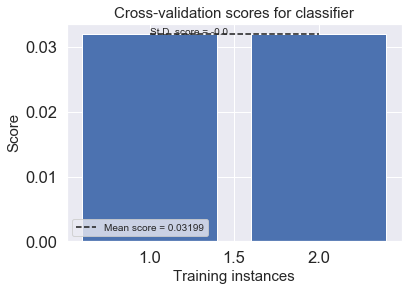

In [35]:
import timeit
start = timeit.default_timer()

# 1,296 models in total
grid = {'n_estimators':[10, 50, 80, 100, 200, 400],  # Number of trees, 100-500 is usually sufficient /
       'max_depth':[2, 3, 4, 5, 6, 7],  # Depth of the tree, 5-6 is usually default
       'max_features':[*range(15,21,1)],  # Number of variables randomly sampled as candidates at each split, sqrt(p) is usually the default
       'min_samples_leaf': [1, 10, 100], # Minimum number of observations in each leaf, 10 is usually default
       'criterion': ['gini', 'entropy']} # Minimum number of observations in each leaf, 10 is usually default
        
rf_grid_random_search_model = mb.grid_search_cv(
    n_splits = 2, # Number of cross-validation splits
    classifier = RandomForestClassifier, # Classifier name, e.g. RandomForestClassifier
    keras_function = None, # Define Keras function. If Keras is not used, then leave this parameter blank
    grid_params = grid, # Grid space
    dev_df = dev,  # Development sample that this will analysis will be performed
    feats = feats_best_rf_back, # List of predictor names
    target = target_variable_name, # Target variable name
    weight_variable = weight_variable_name, # Weight variable name
    randomized_search = True, # Set to True if randomized grid search will be performed, or to False if exhaustive grid search will be performed
    n_random_grids = 100, # Number of grid searches when randomized_search=True. If randomized_search=False, then this parameter is not applicable
    random_state = None, # If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.
    n_jobs = 8 # Number of jobs to run in parallel
)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  32.133352299999984

# Save the best parameters
opt_params_random = rf_grid_random_search_model.best_params_
print('The best hyperparameter set is:', opt_params_random)
print('Mean loss function for cross-validation test data: ', -rf_grid_random_search_model.cv_results_['mean_test_score'][rf_grid_random_search_model.best_index_])
print('Standard deviation loss function for cross-validation test data: ', rf_grid_random_search_model.cv_results_['std_test_score'][rf_grid_random_search_model.best_index_])
#print('Mean Gini for OOT data', 2*rf_grid_random_search_model.score(oos[feats_best_rf_back], oos[target_variable_name])-1)

ev.plot_cross_validation_score(model=rf_grid_random_search_model)

# Compute the score for the OOT data
oos['rf_score_random'] = rf_grid_random_search_model.predict_proba(oos[feats_best_rf_back].values)[:,1]

### Grid search based on GridSearchCV - also uses cross-validation

Execution time in seconds:  41.515959399999986
The best hyperparameter set is: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 18, 'min_samples_leaf': 1, 'n_estimators': 200}
Mean loss function for cross-validation test data:  0.028860473441853253
Standard deviation loss function for cross-validation test data:  0.0020656039592368766


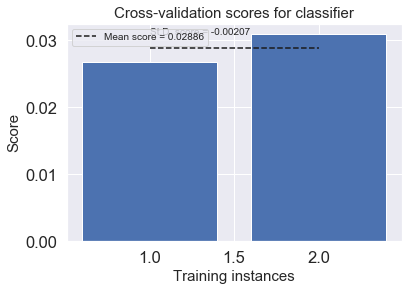

In [36]:
import timeit
start = timeit.default_timer()

# 72 models in total
grid = {'n_estimators':[100, 200],  # Number of trees, 100-500 is usually sufficient /
       'max_depth':[3, 5, 7],  # Depth of the tree, 5-6 is usually default
       'max_features':[18, 21, 24],  # Number of variables randomly sampled as candidates at each split, sqrt(p) is usually the default
       'min_samples_leaf': [1, 10], # Minimum number of observations in each leaf, 10 is usually default
       'criterion': ['gini', 'entropy']} # Minimum number of observations in each leaf, 10 is usually default
        
rf_grid_fixed_search_model = mb.grid_search_cv(
    n_splits = 2, # Number of cross-validation splits
    classifier = RandomForestClassifier, # Classifier name, e.g. RandomForestClassifier
    keras_function = None, # Define Keras function. If Keras is not used, then leave this parameter blank
    grid_params = grid, # Grid space
    dev_df = dev,  # Development sample that this will analysis will be performed
    feats = feats_best_rf_back, # List of predictor names
    target = target_variable_name, # Target variable name
    weight_variable = weight_variable_name, # Weight variable name
    randomized_search = False, # Set to True if randomized grid search will be performed, or to False if exhaustive grid search will be performed
    n_random_grids = 1, # Number of grid searches when randomized_search=True. If randomized_search=False, then this parameter is not applicable
    random_state = None, # If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.
    n_jobs = 8 # Number of jobs to run in parallel
)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  41.59971730000001

# Save the best parameters
opt_params_fixed = rf_grid_fixed_search_model.best_params_
print('The best hyperparameter set is:', opt_params_fixed)
print('Mean loss function for cross-validation test data: ', -rf_grid_fixed_search_model.cv_results_['mean_test_score'][rf_grid_fixed_search_model.best_index_])
print('Standard deviation loss function for cross-validation test data: ', rf_grid_fixed_search_model.cv_results_['std_test_score'][rf_grid_fixed_search_model.best_index_])
#print('Mean Gini for OOT data', 2*rf_grid_fixed_search_model.score(oos[feats_best_rf_back], oos[target_variable_name], sample_weight=oos[weight_variable_name])-1)

ev.plot_cross_validation_score(model=rf_grid_fixed_search_model)

# Compute the score for the OOT data
oos['rf_score_fixed'] = rf_grid_fixed_search_model.predict_proba(oos[feats_best_rf_back].values)[:, 1]

## Calculate RF feature importance

In [37]:
# Load RF machine leanring library
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

# Define the random forest model
opt_params = opt_params_random
rf = RandomForestClassifier(n_estimators=[x[1] for x in list(opt_params.items()) if x[0]=='n_estimators'][0], 
                            max_depth=[x[1] for x in list(opt_params.items()) if x[0]=='max_depth'][0], 
                            max_features=[x[1] for x in list(opt_params.items()) if x[0]=='max_features'][0], 
                            min_samples_leaf=[x[1] for x in list(opt_params.items()) if x[0]=='min_samples_leaf'][0], 
                            criterion=[x[1] for x in list(opt_params.items()) if x[0]=='criterion'][0], 
                            random_state=0)

# Train the model
rf_model = mb.fit_model_weight(dev, feats_best_rf_back, target_variable_name, weight_variable_name, rf, 'rf.pkl')

# Calculate feature importance
feat_imprtnce_dictnry = mb.feature_imp(rf_model, feats_best_rf_back)
for key, value in sorted(feat_imprtnce_dictnry.items(), key=lambda item: item[1], reverse=True):
    print("%s: %s" % (key, value))

numeric7: 0.8041898172081962
numeric6: 0.12242523088307485
numeric8: 0.06259933349802281
numeric4: 0.004517066848519771
numeric2: 0.0031815236637191143
numeric1: 0.00298610303170843
character2_nan: 9.078291871897106e-05
character2_1.0: 5.083979347833194e-06
character6_5: 5.048163012541871e-06
character6_9: 9.805679594365038e-09
character1_6: 0.0
character2_7.0: 0.0
character6_10: 0.0
character6_17: 0.0
character6_22: 0.0
character6_23: 0.0
character1_4: 0.0
character6_16: 0.0
character6_13: 0.0
character2_2.0: 0.0
character2_6.0: 0.0
character1_10: 0.0
character2_9.0: 0.0
character6_3: 0.0
character1_0: 0.0


## Calculate RF log-loss

In [38]:
from sklearn.metrics import log_loss
print ("log-loss_iterative")
print(log_loss(y_true=oos[target_variable_name].values, y_pred=oos['rf_score_iterative'].values, sample_weight=oos[weight_variable_name].values, eps=1e-15))
print ("log-loss_fixed")
print(log_loss(y_true=oos[target_variable_name].values, y_pred=oos['rf_score_fixed'].values, sample_weight=oos[weight_variable_name].values, eps=1e-15))
print ("log-loss_random")
print(log_loss(y_true=oos[target_variable_name].values, y_pred=oos['rf_score_random'].values, sample_weight=oos[weight_variable_name].values, eps=1e-15))

log-loss_iterative
0.0357599693017663
log-loss_fixed
0.028873589036422374
log-loss_random
0.03009368235391351


## Calculate RF Precision/Recall Area Under the Curve

In [39]:
print ("precision_recall_auc_iterative")
print(ev.auc_precision_recall(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_score_iterative', 
                            weight_variable=weight_variable_name))
print ("precision_recall_auc_fixed")
print(ev.auc_precision_recall(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_score_fixed', 
                            weight_variable=weight_variable_name))
print ("precision_recall_auc_random")
print(ev.auc_precision_recall(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_score_random', 
                            weight_variable=weight_variable_name))

precision_recall_auc_iterative
0.9977128250946696
precision_recall_auc_fixed
0.9991725261694611
precision_recall_auc_random
0.9990880162960283


## Calculate RF Gini, for the top population

In [40]:
print ("unit_gini_iterative")
print(ev.calculate_gini(
    table_name=oos, # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='rf_score_iterative', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))
print ("unit_gini_fixed")
print(ev.calculate_gini(
    table_name=oos, # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='rf_score_fixed', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))
print ("unit_gini_random")
print(ev.calculate_gini(
    table_name=oos, # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='rf_score_random', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))

unit_gini_iterative
0.9965105446428342
unit_gini_fixed
0.9984218448889259
unit_gini_random
0.997993477687406


## Calculate RF Lifting table

In [41]:
# Lifting table
lt_rf_iterative = ev.lift_table_weight(oos[['rf_score_iterative', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_rf_fixed = ev.lift_table_weight(oos[['rf_score_fixed', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_rf_random = ev.lift_table_weight(oos[['rf_score_random', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_rf_iterative

,Quantile Unit,# Cases,# Responses,Cumulative # Responses,% Response,FPR,Cumulative FPR,ADR,Cumulative ADR,Lift,Cumulative Lift,Quantile Value,Value,Cumulative Value,VDR,Cumulative VDR
0,0.100,454.388,454.388,454.388,1.000,0.000000e+00,0.000,0.200,0.200,2.005,2.005,0.100,4557558.745,4.557559e+06,0.202,0.202
1,0.200,458.515,454.852,909.240,0.992,8.000000e-03,0.004,0.200,0.399,1.989,1.997,0.200,4470705.132,9.028264e+06,0.198,0.400
2,0.300,455.529,455.529,1364.769,1.000,0.000000e+00,0.003,0.200,0.599,2.005,1.999,0.300,4467145.778,1.349541e+07,0.198,0.598
3,0.400,456.788,455.688,1820.456,0.998,2.000000e-03,0.003,0.200,0.799,2.000,1.999,0.400,4509982.925,1.800539e+07,0.200,0.797
4,0.500,455.126,440.275,2260.731,0.967,3.400000e-02,0.009,0.193,0.993,1.939,1.987,0.500,4415975.887,2.242137e+07,0.196,0.993
5,0.599,456.075,12.982,2273.714,0.028,3.413100e+01,0.204,0.006,0.998,0.057,1.666,0.599,122630.516,2.254400e+07,0.005,0.998
6,0.700,458.822,3.452,2277.165,0.008,1.319290e+02,0.403,0.002,1.000,0.015,1.429,0.700,41268.653,2.258527e+07,0.002,1.000
7,0.800,456.726,0.000,2277.165,0.000,1.000000e+09,0.604,0.000,1.000,0.000,1.250,0.800,0.000,2.258527e+07,0.000,1.000
8,0.900,455.472,0.000,2277.165,0.000,1.000000e+09,0.804,0.000,1.000,0.000,1.111,0.900,0.000,2.258527e+07,0.000,1.000
9,1.000,457.625,0.000,2277.165,0.000,1.000000e+09,1.005,0.000,1.000,0.000,1.000,1.000,0.000,2.258527e+07,0.000,1.000


## Plots RF

### Plot RF Detection rate vs. Population Distribution

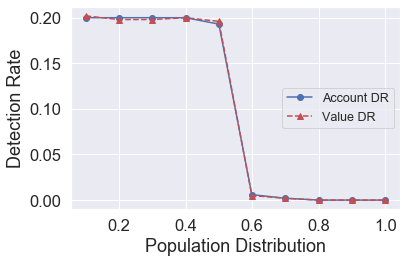

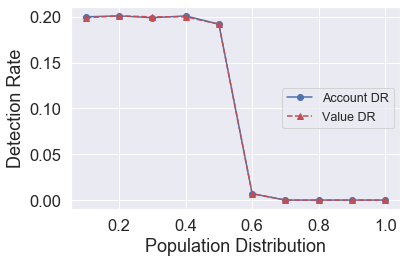

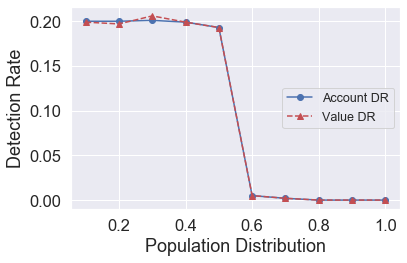

In [42]:
ev.plot_ADR_Quantile(lt_rf_iterative)
ev.plot_ADR_Quantile(lt_rf_fixed)
ev.plot_ADR_Quantile(lt_rf_random)

### Plot RF Cum. Detection rate vs. Population Distribution (Gains chart)

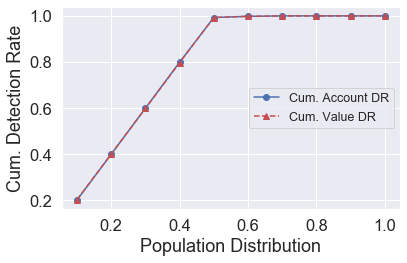

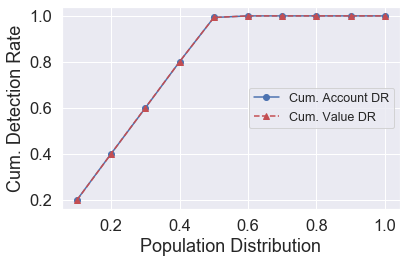

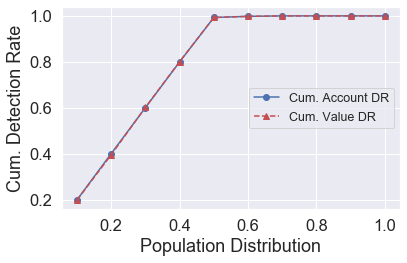

In [43]:
ev.plot_cADR_Quantile(lt_rf_iterative)
ev.plot_cADR_Quantile(lt_rf_fixed)
ev.plot_cADR_Quantile(lt_rf_random)

### Plot RF FPR vs. Population Distribution

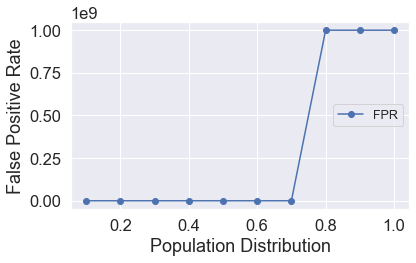

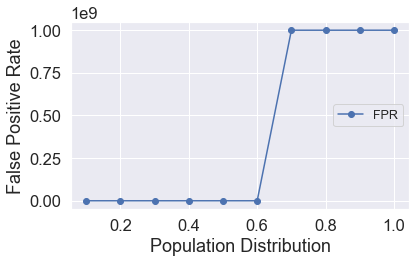

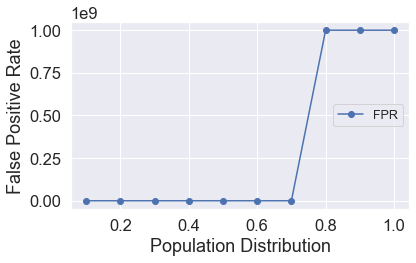

In [44]:
ev.plot_FPR_Quantile(lt_rf_iterative)
ev.plot_FPR_Quantile(lt_rf_fixed)
ev.plot_FPR_Quantile(lt_rf_random)

### Plot RF Cum. FPR vs. Population Distribution

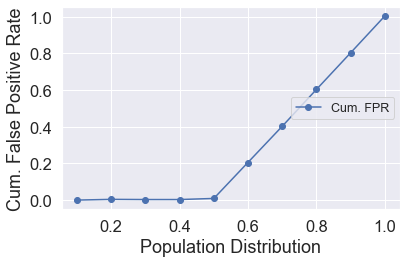

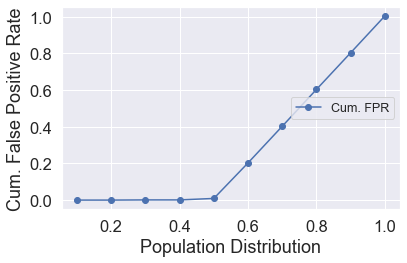

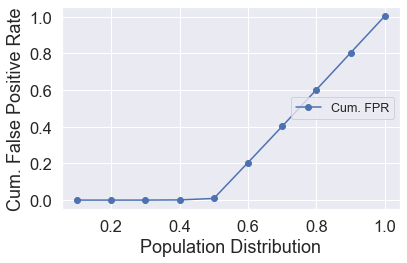

In [45]:
ev.plot_cFPR_Quantile(lt_rf_iterative)
ev.plot_cFPR_Quantile(lt_rf_fixed)
ev.plot_cFPR_Quantile(lt_rf_random)

### Plot RF ROC curve

Random: ROC AUC=0.500
Model: ROC AUC=0.998


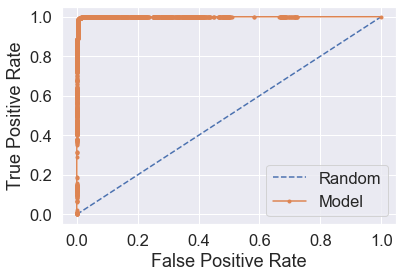

Random: ROC AUC=0.500
Model: ROC AUC=0.999


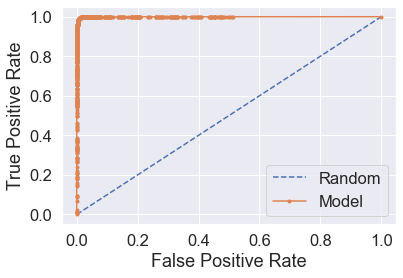

Random: ROC AUC=0.500
Model: ROC AUC=0.999


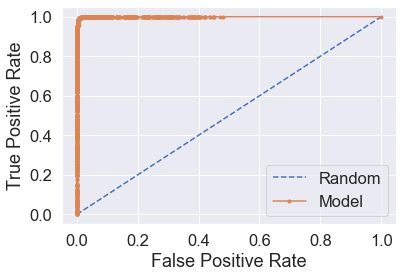

In [46]:
ev.plot_ROC_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_score_iterative', weight_variable=weight_variable_name) 
ev.plot_ROC_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_score_fixed', weight_variable=weight_variable_name) 
ev.plot_ROC_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_score_random', weight_variable=weight_variable_name) 

### Plot RF Precision Recall curve

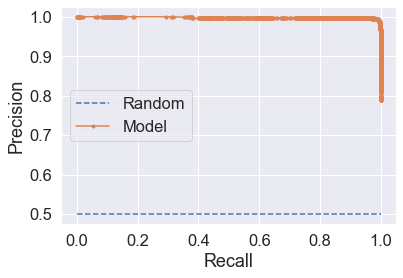

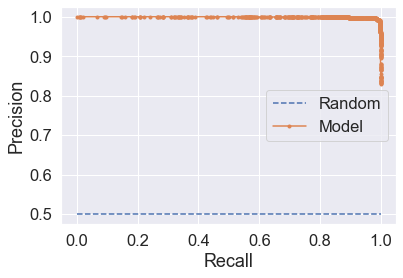

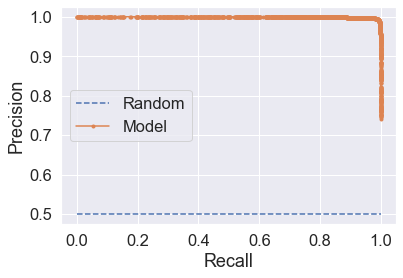

In [47]:
ev.plot_precision_recall_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_score_iterative', 
                            weight_variable=weight_variable_name)
ev.plot_precision_recall_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_score_fixed', 
                            weight_variable=weight_variable_name)
ev.plot_precision_recall_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_score_random', 
                            weight_variable=weight_variable_name)  

### Plot RF F1 score, Accuracy, Sensitivity, Specificity, Precision vs Cutoff

..\functions\evaluation.py:561: RuntimeWarning: invalid value encountered in double_scalars
  model_precision = true_positive/(true_positive+false_positive)


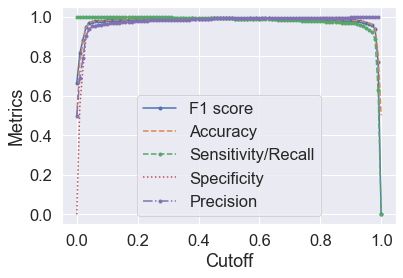

..\functions\evaluation.py:561: RuntimeWarning: invalid value encountered in double_scalars
  model_precision = true_positive/(true_positive+false_positive)


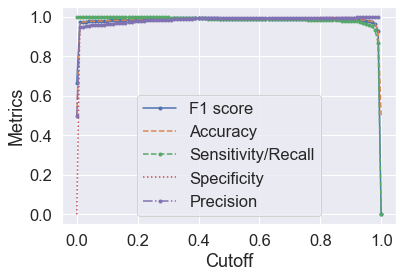

..\functions\evaluation.py:561: RuntimeWarning: invalid value encountered in double_scalars
  model_precision = true_positive/(true_positive+false_positive)


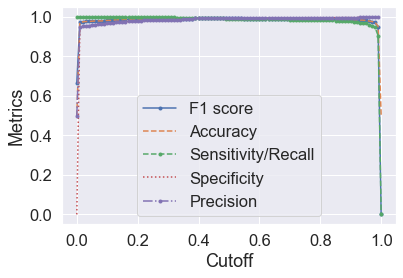

In [48]:
ev.plot_cutoffs(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_score_iterative', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)
ev.plot_cutoffs(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_score_fixed', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)
ev.plot_cutoffs(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_score_random', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)


# Random Forest with H2O

In [49]:
# Load the data
import h2o 
h2o.init(nthreads=8, max_mem_size=12)

# load pandas dataframe into H2O dataframe
dev_h2o = h2o.H2OFrame(dev)
oos_h2o = h2o.H2OFrame(oos)

# Define response variable to be categorical for classification model.
dev_h2o[target_variable_name]=dev_h2o[target_variable_name].asfactor()
oos_h2o[target_variable_name]=oos_h2o[target_variable_name].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.202-b08, mixed mode)
  Starting server from C:\Data_Science\Anaconda3\envs\envpip\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\creep\AppData\Local\Temp\tmp2htqdsbs
  JVM stdout: C:\Users\creep\AppData\Local\Temp\tmp2htqdsbs\h2o_creep_started_from_python.out
  JVM stderr: C:\Users\creep\AppData\Local\Temp\tmp2htqdsbs\h2o_creep_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,04 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.2
H2O cluster version age:,8 months and 13 days !!!
H2O cluster name:,H2O_from_python_creep_p3d0p1
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


## Feature selection RF

In [50]:
# Provide input data to feature selection class
select = fs.SelectBest_weight(df=dev, target=target_variable_name, weight=weight_variable_name)

In [51]:
# Select top features to apply a first screening
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=1234, n_jobs=6)
rf_importance, feats_best_rf = select.top_rf_feat(feats=keep_gini_vars, model=model_rf, n=30)
print('The top Random Forest features are: \n', feats_best_rf)
rf_importance

The top Random Forest features are: 
 ['numeric7', 'numeric8', 'numeric6', 'numeric4', 'numeric1', 'numeric2', 'character1_6', 'character2_nan', 'character2_7.0', 'character2_1.0', 'character6_10', 'character6_17', 'character6_22', 'character6_9', 'character6_23', 'character6_4', 'character6_5', 'character1_4', 'character1_9', 'character6_16', 'character1_5', 'character6_13', 'character2_2.0', 'character2_6.0', 'character1_10', 'character2_9.0', 'character6_3', 'character1_0', 'character1_8', 'character6_7']


[('numeric7', 0.4873990357878703),
 ('numeric8', 0.23328315139433564),
 ('numeric6', 0.2310080312038563),
 ('numeric4', 0.009805961133907701),
 ('numeric1', 0.009748748089330553),
 ('numeric2', 0.008111966268427933),
 ('character1_6', 0.004285806308962155),
 ('character2_nan', 0.002285397005738274),
 ('character2_7.0', 0.0017733356068777332),
 ('character2_1.0', 0.0014308831574950172),
 ('character6_10', 0.0012914339085180653),
 ('character6_17', 0.001220774582266416),
 ('character6_22', 0.0010960269821570583),
 ('character6_9', 0.0010952931257780442),
 ('character6_23', 0.0010520317665548412),
 ('character6_4', 0.0008854611549683485),
 ('character6_5', 0.0008020041006688255),
 ('character1_4', 0.0005777292877041759),
 ('character1_9', 0.000531761190517353),
 ('character6_16', 0.0004880451218871219),
 ('character1_5', 0.0003816636068172413),
 ('character6_13', 0.0003645328602433314),
 ('character2_2.0', 0.00024415521947809067),
 ('character2_6.0', 0.00015429961717693756),
 ('character1

In [52]:
import timeit
start = timeit.default_timer()

# Backward selection with random forest model: In each step a feature is selected to remove - this removal maximizes Gini
feats_best_rf_back = select.backward_recur(feats=feats_best_rf, oos=oos, model=model_rf, min_feats=25, classification=True)
print(feats_best_rf_back)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
# Execution time in seconds:  84.96231860000003

step i = 1 feature removed: character6_7 gini: 0.9970970306174713
step i = 2 feature removed: character1_9 gini: 0.9972231526236388
step i = 3 feature removed: character6_4 gini: 0.9970337498892661
step i = 4 feature removed: character1_8 gini: 0.9968328623030625
step i = 5 feature removed: character1_5 gini: 0.9972115217517634
['numeric7', 'numeric8', 'numeric6', 'numeric4', 'numeric1', 'numeric2', 'character1_6', 'character2_nan', 'character2_7.0', 'character2_1.0', 'character6_10', 'character6_17', 'character6_22', 'character6_9', 'character6_23', 'character6_5', 'character1_4', 'character6_16', 'character6_13', 'character2_2.0', 'character2_6.0', 'character1_10', 'character2_9.0', 'character6_3', 'character1_0']
Execution time in seconds:  98.24241329999995


## Grid search and train RF machine learning model

### Grid search based on iterative step

In [53]:
# Hyperparameter tuning: The process works as follows:
# 1) Iterate n_estimators (grid) for the fixed values of max_depth and max_features (params). Select the value of n_estimators that minimizes the loss function. 
# 2) Keep the n_estimators value from the previous step. Iterate max_depth (grid) for the fixed value of max_features (params). Select the value of max_depth that minimizes the loss function. 
# 3) Keep the max_depth value from the previous step. Iterate max_features (grid). Select the value of max_features that minimizes the loss function. 
import timeit
start = timeit.default_timer()

import math
# 18 models in total
grid = {'n_estimators':[10, 50, 80, 100, 200, 400],  # Number of trees, 100-500 is usually sufficient /
       'max_depth':[2, 5, 10, 20],  # Depth of the tree, 5-6 is usually default
       'max_features':[*range(1,len(feats_best_rf_back),math.ceil(len(feats_best_rf_back)/5))],  # Number of variables randomly sampled as candidates at each split, sqrt(p) is usually the default
       'min_samples_leaf': [1, 10, 100]} # Minimum number of observations in each leaf, 10 is usually default

params = {'n_estimators': 100, 'max_depth':10, 'max_features':math.ceil(math.sqrt(len(feats_best_rf_back))), 'min_samples_leaf':10}

opt_params_iterative, loss = mb.step_search_weight(estimator=RandomForestClassifier, params=params, grid=grid, target=target_variable_name, 
                                  weight=weight_variable_name, dev=dev, val=oos, keep=feats_best_rf_back)
print('\n Best Parameters')
print(opt_params_iterative)
print(loss)

# Load RF machine leanring library
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

# Define the random forest model
rf = RandomForestClassifier(n_estimators=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='n_estimators'][0], 
                            max_depth=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='max_depth'][0], 
                            max_features=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='max_features'][0], 
                            min_samples_leaf=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='min_samples_leaf'][0], 
                            random_state=0)

# Train the model
rf_model = mb.fit_model_weight(dev, feats_best_rf_back, target_variable_name, weight_variable_name, rf, 'rf_iterative.pkl')

# Compute the score for the OOT data
oos['rf_score_iterative'] = rf_model.predict_proba(oos[feats_best_rf_back].values)[:, 1]

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  4.643848800000001

Search Progress:
{'n_estimators': 10, 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 10} n_estimators 10 0.21746354843770122 0.21746354843770122
{'n_estimators': 50, 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 10} n_estimators 50 0.19813576803927704 0.19813576803927704
{'n_estimators': 80, 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 10} n_estimators 80 0.1857805682929181 0.1857805682929181
{'n_estimators': 80, 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 10} n_estimators 100 0.20240639602758573 0.1857805682929181
{'n_estimators': 80, 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 10} n_estimators 200 0.19970217867264758 0.1857805682929181
{'n_estimators': 80, 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 10} n_estimators 400 0.2092834234031656 0.1857805682929181

{'n_estimators': 80, 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 10} max_depth 2 0.31055909771316975 0.1857805682929181
{'n_estimators': 80, 'max_depth

### Grid search based on H2O random grid space

In [54]:
import timeit
start = timeit.default_timer()

# Hyperparameter tuning using H2O random grid space: - NOTE: THIS TAKES 5 MINUTES TO RUN!
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import H2ORandomForestEstimator
import math

# RF hyperparameters
# 1,440 models in total
grid_h2o_random = {'ntrees': [i*50 for i in range(1, 10)], # Number of trees, 100-500 is usually sufficient
                'max_depth': list(range(2, 20, 3)), # Depth of the tree, 5-6 is usually default
                'mtries': [i*2 for i in range(1, math.ceil(len(feats_best_rf_back)/2))], # Number of variables randomly sampled as candidates at each split, sqrt(p) is usually the default
                'min_rows': [1, 10, 100], # Minimum number of observations in each leaf, 10 is usually default
                'nbins': [20, 30], #For numerical columns (real/int), build a histogram of (at least) this many bins, then split at the best point, 30 is usually default
                'nbins_cats': [10, 15], # For categorical columns (factors), build a histogram of this many bins, then split at the best point. Higher values can lead to more overfitting, 10-20 is usally default
                'sample_rate': [0.63], # Row sample rate per tree (from 0.0 to 1.0), 0.63 is usually default
                'col_sample_rate_per_tree': [1]} # Column sample rate per tree (from 0.0 to 1.0), 1 is usually default

# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 10, 'seed': 1}

# Train and validate a random grid of RFs
rf_h2o_grid_random = H2OGridSearch(model=H2ORandomForestEstimator,
                          grid_id='rf_h2o_grid_random',
                          hyper_params=grid_h2o_random,
                          search_criteria=search_criteria)

rf_h2o_grid_random.train(x=feats_best_rf_back, y=target_variable_name, training_frame=dev_h2o, validation_frame=oos_h2o, 
                         weights_column=weight_variable_name, seed=1, nfolds=0)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
# Execution time in seconds:  53.19511840000001

# Get the grid results, sorted by validation logloss
rf_h2o_grid_random_perf = rf_h2o_grid_random.get_grid(sort_by='logloss', decreasing=False)
print(rf_h2o_grid_random_perf)

drf Grid Build progress: |████████████████████████████████████████████████| 100%
Execution time in seconds:  50.49609939999999
    col_sample_rate_per_tree max_depth min_rows mtries nbins nbins_cats  \
0                        1.0        11      1.0     10    30         10   
1                        1.0        17      1.0      8    20         10   
2                        1.0         5    100.0     14    20         10   
3                        1.0        17    100.0     10    30         10   
4                        1.0        14     10.0     16    20         15   
5                        1.0        17      1.0     22    30         10   
6                        1.0         2      1.0     14    20         15   
7                        1.0        17    100.0      8    30         15   
8                        1.0         2      1.0      8    30         10   
9                        1.0         2    100.0      2    30         10   

  ntrees sample_rate                    model_i

In [55]:
# Build random forest model in H2O, based on the H2O random grid search. Grab the best model.
rf_h2o_random = rf_h2o_grid_random_perf.models[0]

# Check the random forest model performance on the OOT sample
rf_h2o_model_performance = rf_h2o_random.model_performance(oos_h2o)
print(rf_h2o_model_performance)
print('Gini for the OOT sample is: ', 2*rf_h2o_model_performance.auc()-1)

# Check the variable importance 
var_imp=[(x[0],x[2]) for x in rf_h2o_random.varimp()]
for v1, v2 in var_imp:
    print (v1,v2)
    
# Get probability score for test dataset
oos_h2o['rf_h2o_score_random'] = rf_h2o_random.predict(oos_h2o)[2]


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.0069023485955191964
RMSE: 0.08308037431017747
LogLoss: 0.03175932016342867
Mean Per-Class Error: 0.007283089890273597
AUC: 0.9990703632092055
AUCPR: 0.2268029908081887
Gini: 0.998140726418411

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5300064397071089: 


,,0,1,Error,Rate
0,0,2272.0,15.0,0.0066,(15.0/2287.0)
1,1,17.0,2259.0,0.0075,(17.0/2276.0)
2,Total,2289.0,2274.0,0.007,(32.0/4563.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.530006,0.992698,234.0
1,max f2,0.251146,0.994405,263.0
2,max f0point5,0.673762,0.993303,221.0
3,max accuracy,0.530006,0.992718,234.0
4,max precision,1.000000,1.000000,0.0
5,max recall,0.000029,1.000000,399.0
6,max specificity,1.000000,1.000000,0.0
7,max absolute_mcc,0.530006,0.985436,234.0
8,max min_per_class_accuracy,0.530006,0.992258,234.0
9,max mean_per_class_accuracy,0.530006,0.992717,234.0



Gains/Lift Table: Avg response rate: 49.47 %, avg score: 78.42 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.000000,1.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000,-100.000000,NaN
1,,2,0.383901,1.000000,2.021558,2.021558,1.000000,1.575907,1.000000,1.575907,0.776078,0.776078,102.155772,102.155772
2,,3,0.480220,0.933501,1.985458,2.014317,0.982143,1.578350,0.996418,1.576397,0.191238,0.967316,98.545847,101.431718
3,,4,1.000000,0.000029,0.062881,1.000000,0.031105,0.052358,0.494668,0.784232,0.032684,1.000000,-93.711899,0.000000




Gini for the OOT sample is:  0.998140726418411
numeric7 1.0
numeric6 0.21281152486952257
numeric8 0.1190838884614794
numeric4 0.00625787122582584
numeric2 0.004375904310758056
numeric1 0.0036458784487390893
character2_nan 0.00013529693347745338
character2_1.0 1.4658535367238642e-05
character1_6 1.0010402931675759e-05
character6_5 8.595989925354538e-06
character6_3 1.3146014274329396e-06
character6_13 3.9231524470023347e-07
character6_9 2.3405004074533705e-09
character1_4 0.0
character1_0 0.0
character1_10 0.0
character2_2.0 0.0
character2_6.0 0.0
character2_7.0 0.0
character2_9.0 0.0
character6_10 0.0
character6_16 0.0
character6_17 0.0
character6_22 0.0
character6_23 0.0
drf prediction progress: |████████████████████████████████████████████████| 100%


### Grid search based on H2O fixed grid space

In [56]:
# Hyperparameter tuning using H2O fixed grid space: - NOTE: THIS TAKES SEVERAL MINUTES TO RUN!
import timeit
start = timeit.default_timer()

from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import H2ORandomForestEstimator
import math

# 27 models in total
grid_h2o_fixed = {'ntrees':[50, 100, 200],  # Number of trees, 100-500 is usually sufficient
       'max_depth':[8, 10, 12],  # Depth of the tree, 5-6 is usually default
       'mtries':[14, 16, 18],  # Number of variables randomly sampled as candidates at each split, sqrt(p) is usually the default
        'min_rows': [10],  # Minimum number of observations in each leaf, 10 is usually default
        'nbins': [30],  #For numerical columns (real/int), build a histogram of (at least) this many bins, then split at the best point, 30 is usually default
        'nbins_cats': [15],  # For categorical columns (factors), build a histogram of this many bins, then split at the best point. Higher values can lead to more overfitting, 10-20 is usally default
        'sample_rate': [0.63],  # Row sample rate per tree (from 0.0 to 1.0), 0.63 is usually default
        'col_sample_rate_per_tree': [1]} # Column sample rate per tree (from 0.0 to 1.0), 1 is usually default

# Train and validate a cartesian grid of RFs
rf_h2o_grid_fixed = H2OGridSearch(model=H2ORandomForestEstimator,
                          grid_id='rf_h2o_grid_fixed',
                          hyper_params=grid_h2o_fixed)

rf_h2o_grid_fixed.train(x=feats_best_rf_back, y=target_variable_name, training_frame=dev_h2o, validation_frame=oos_h2o, 
                        weights_column=weight_variable_name, seed=1, nfolds=0)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
# Execution time in seconds:  93.57661189999999

# Get the grid results, sorted by validation logloss
rf_h2o_grid_fixed_perf = rf_h2o_grid_fixed.get_grid(sort_by='logloss', decreasing=False)
print(rf_h2o_grid_fixed_perf)

drf Grid Build progress: |████████████████████████████████████████████████| 100%
Execution time in seconds:  89.52225349999998
     col_sample_rate_per_tree max_depth min_rows mtries nbins nbins_cats  \
0                         1.0         8     10.0     14    30         15   
1                         1.0        10     10.0     14    30         15   
2                         1.0         8     10.0     16    30         15   
3                         1.0         8     10.0     16    30         15   
4                         1.0        10     10.0     16    30         15   
5                         1.0        12     10.0     16    30         15   
6                         1.0         8     10.0     18    30         15   
7                         1.0        12     10.0     14    30         15   
8                         1.0         8     10.0     18    30         15   
9                         1.0         8     10.0     18    30         15   
10                        1.0        

In [57]:
# Build fixed forest model in H2O, based on the H2O fixed grid search. Grab the best model.
rf_h2o_fixed = rf_h2o_grid_fixed_perf.models[0]

# Check the random forest model performance on the OOT sample
rf_h2o_model_performance = rf_h2o_fixed.model_performance(oos_h2o)
print(rf_h2o_model_performance)
print('Gini for the OOT sample is: ', 2*rf_h2o_model_performance.auc()-1)

# Check the variable importance 
var_imp=[(x[0],x[2]) for x in rf_h2o_fixed.varimp()]
for v1, v2 in var_imp:
    print (v1,v2)
    
# Get probability score for test dataset
oos_h2o['rf_h2o_score_fixed'] = rf_h2o_fixed.predict(oos_h2o)[2]


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.007087311686209054
RMSE: 0.08418617277325922
LogLoss: 0.031512948744922435
Mean Per-Class Error: 0.007830557720655218
AUC: 0.9991304640642465
AUCPR: 0.2391062430862496
Gini: 0.9982609281284931

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.494611624777317: 


,,0,1,Error,Rate
0,0,2267.0,20.0,0.0087,(20.0/2287.0)
1,1,15.0,2262.0,0.0066,(15.0/2277.0)
2,Total,2282.0,2282.0,0.0077,(35.0/4564.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.494612,0.992158,230.0
1,max f2,0.198757,0.994175,256.0
2,max f0point5,0.622193,0.992643,216.0
3,max accuracy,0.494612,0.992167,230.0
4,max precision,0.999996,1.000000,0.0
5,max recall,0.000048,1.000000,398.0
6,max specificity,0.999996,1.000000,0.0
7,max absolute_mcc,0.494612,0.984336,230.0
8,max min_per_class_accuracy,0.540120,0.991391,223.0
9,max mean_per_class_accuracy,0.494612,0.992169,230.0



Gains/Lift Table: Avg response rate: 49.47 %, avg score: 78.47 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.000000,0.999998,0.000000,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000,-100.000000,NaN
1,,2,0.016168,0.999998,2.021558,2.021558,1.000000,1.486498,1.000000,1.486498,0.032684,0.032684,102.155772,102.155772
2,,3,0.376333,0.999996,2.021558,2.021558,1.000000,1.586286,1.000000,1.581999,0.728095,0.760779,102.155772,102.155772
3,,4,0.479532,0.948075,1.987865,2.014307,0.983333,1.554747,0.996413,1.576134,0.205146,0.965925,98.786509,101.430679
4,,5,0.593739,0.000449,0.298362,1.684241,0.147590,0.253382,0.833140,1.321700,0.034075,1.000000,-70.163757,68.424102
5,,6,1.000000,0.000000,0.000000,1.000000,0.000000,0.000010,0.494668,0.784749,0.000000,1.000000,-100.000000,0.000000




Gini for the OOT sample is:  0.9982609281284931
numeric7 1.0
numeric6 0.16137517701201481
numeric8 0.0732646796870425
numeric4 0.0026021514212355443
numeric2 0.001376384049769024
numeric1 0.0007935311176861849
character2_nan 2.4317903310647525e-05
character1_4 0.0
character1_0 0.0
character1_6 0.0
character1_10 0.0
character2_2.0 0.0
character2_1.0 0.0
character2_6.0 0.0
character2_7.0 0.0
character2_9.0 0.0
character6_9 0.0
character6_10 0.0
character6_5 0.0
character6_13 0.0
character6_3 0.0
character6_16 0.0
character6_17 0.0
character6_22 0.0
character6_23 0.0
drf prediction progress: |████████████████████████████████████████████████| 100%


In [58]:
# Convert H2O dataframe to pandas dataframe
oos=oos_h2o.as_data_frame(use_pandas=True)

## Calculate H2O RF log-loss

In [59]:
from sklearn.metrics import log_loss
print ("log-loss_iterative")
print(log_loss(y_true=oos[target_variable_name].values, y_pred=oos['rf_score_iterative'].values, sample_weight=oos[weight_variable_name].values, eps=1e-15))
print ("log-loss_fixed")
print(log_loss(y_true=oos[target_variable_name].values, y_pred=oos['rf_h2o_score_fixed'].values, sample_weight=oos[weight_variable_name].values, eps=1e-15))
print ("log-loss_random")
print(log_loss(y_true=oos[target_variable_name].values, y_pred=oos['rf_h2o_score_random'].values, sample_weight=oos[weight_variable_name].values, eps=1e-15))

log-loss_iterative
0.03575996930176628
log-loss_fixed
0.031512948744922845
log-loss_random
0.03175932016342902


## Calculate H2O RF Precision/Recall Area Under the Curve

In [60]:
print ("precision_recall_auc_iterative")
print(ev.auc_precision_recall(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_score_iterative', 
                            weight_variable=weight_variable_name))
print ("precision_recall_auc_fixed")
print(ev.auc_precision_recall(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_h2o_score_fixed', 
                            weight_variable=weight_variable_name))
print ("precision_recall_auc_random")
print(ev.auc_precision_recall(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_h2o_score_random', 
                            weight_variable=weight_variable_name))

precision_recall_auc_iterative
0.9977128250946696
precision_recall_auc_fixed
0.999135956712501
precision_recall_auc_random
0.9991251945409884


## Calculate H2O RF Gini, for the top population

In [61]:
print ("unit_gini_iterative")
print(ev.calculate_gini(
    table_name=oos, # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='rf_score_iterative', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))
print ("unit_gini_fixed")
print(ev.calculate_gini(
    table_name=oos, # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='rf_h2o_score_fixed', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))
print ("unit_gini_random")
print(ev.calculate_gini(
    table_name=oos, # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='rf_h2o_score_random', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))

unit_gini_iterative
0.9965105446428342
unit_gini_fixed
0.9982605706656364
unit_gini_random
0.9981339131823619


## Calculate H2O RF Lifting table

In [62]:
# Lifting table
lt_rf_h2o_iterative = ev.lift_table_weight(oos[['rf_score_iterative', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_rf_h2o_fixed = ev.lift_table_weight(oos[['rf_h2o_score_fixed', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_rf_h2o_random = ev.lift_table_weight(oos[['rf_h2o_score_random', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_rf_h2o_random

,Quantile Unit,# Cases,# Responses,Cumulative # Responses,% Response,FPR,Cumulative FPR,ADR,Cumulative ADR,Lift,Cumulative Lift,Quantile Value,Value,Cumulative Value,VDR,Cumulative VDR
0,0.099,454.066,454.066,454.066,1.000,0.000000e+00,0.000,0.199,0.199,2.005,2.005,0.099,4488149.262,4.488149e+06,0.199,0.199
1,0.200,458.216,458.216,912.281,1.000,0.000000e+00,0.000,0.201,0.401,2.005,2.005,0.200,4547656.276,9.035806e+06,0.201,0.400
2,0.300,457.134,457.134,1369.415,1.000,0.000000e+00,0.000,0.201,0.601,2.005,2.005,0.300,4611718.952,1.364752e+07,0.204,0.604
3,0.400,455.881,455.881,1825.297,1.000,0.000000e+00,0.000,0.200,0.802,2.005,2.005,0.400,4395778.796,1.804330e+07,0.195,0.799
4,0.500,456.457,434.751,2260.048,0.952,5.000000e-02,0.010,0.191,0.992,1.909,1.986,0.500,4372253.022,2.241556e+07,0.194,0.992
5,0.600,455.270,16.467,2276.515,0.036,2.664700e+01,0.202,0.007,1.000,0.073,1.667,0.600,160530.049,2.257609e+07,0.007,1.000
6,0.700,458.260,0.650,2277.165,0.001,7.038890e+02,0.403,0.000,1.000,0.003,1.429,0.700,9181.278,2.258527e+07,0.000,1.000
7,0.800,455.509,0.000,2277.165,0.000,1.000000e+09,0.603,0.000,1.000,0.000,1.250,0.800,0.000,2.258527e+07,0.000,1.000
8,0.900,456.499,0.000,2277.165,0.000,1.000000e+09,0.804,0.000,1.000,0.000,1.111,0.900,0.000,2.258527e+07,0.000,1.000
9,1.000,457.773,0.000,2277.165,0.000,1.000000e+09,1.005,0.000,1.000,0.000,1.000,1.000,0.000,2.258527e+07,0.000,1.000


## Plots RF H2O

### Plot RF H2O Detection rate vs. Population Distribution

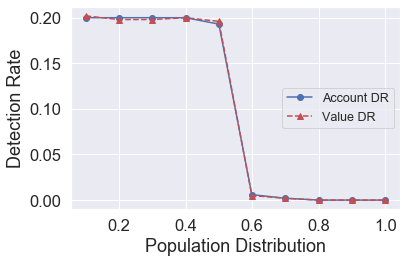

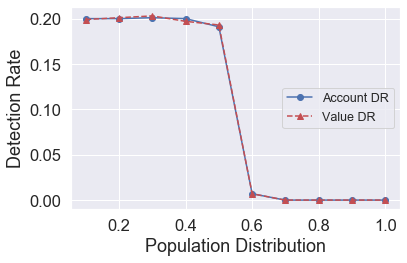

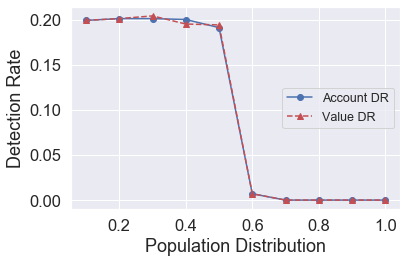

In [63]:
ev.plot_ADR_Quantile(lt_rf_h2o_iterative)
ev.plot_ADR_Quantile(lt_rf_h2o_fixed)
ev.plot_ADR_Quantile(lt_rf_h2o_random)

### Plot RF H2O Cum. Detection rate vs. Population Distribution (Gains chart)

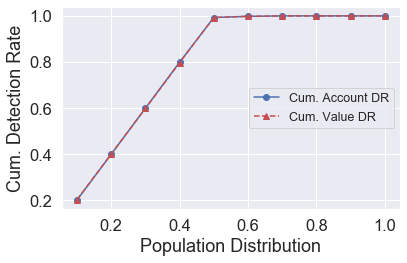

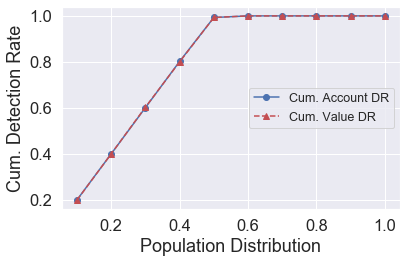

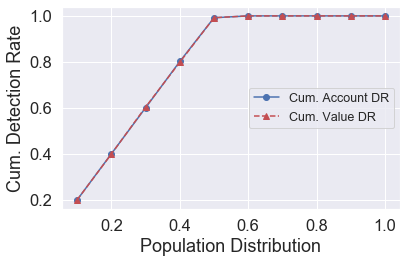

In [64]:
ev.plot_cADR_Quantile(lt_rf_h2o_iterative)
ev.plot_cADR_Quantile(lt_rf_h2o_fixed)
ev.plot_cADR_Quantile(lt_rf_h2o_random)

### Plot RF H2O FPR vs. Population Distribution

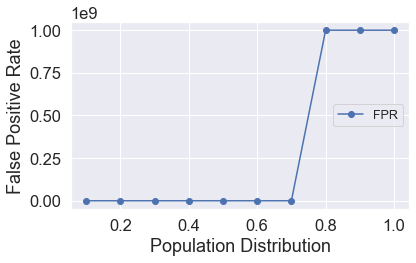

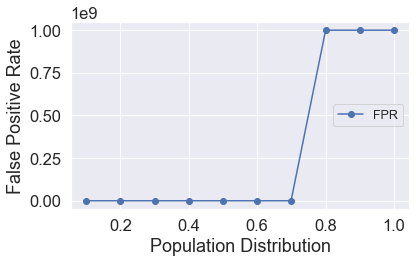

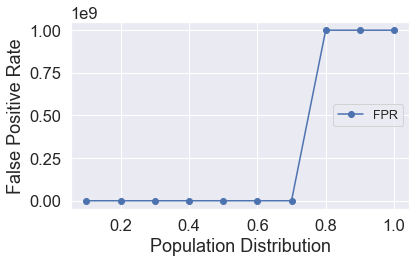

In [65]:
ev.plot_FPR_Quantile(lt_rf_h2o_iterative)
ev.plot_FPR_Quantile(lt_rf_h2o_fixed)
ev.plot_FPR_Quantile(lt_rf_h2o_random)

### Plot RF H2O Cum. FPR vs. Population Distribution

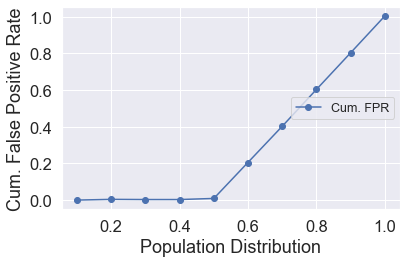

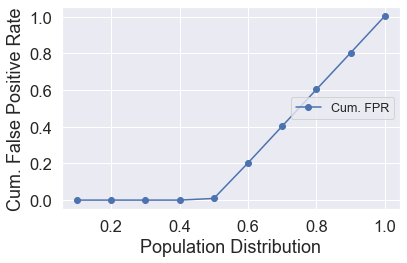

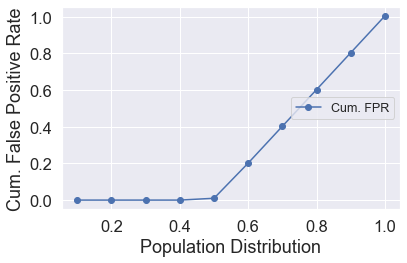

In [66]:
ev.plot_cFPR_Quantile(lt_rf_h2o_iterative)
ev.plot_cFPR_Quantile(lt_rf_h2o_fixed)
ev.plot_cFPR_Quantile(lt_rf_h2o_random)

### Plot RF H2O ROC curve

Random: ROC AUC=0.500
Model: ROC AUC=0.998


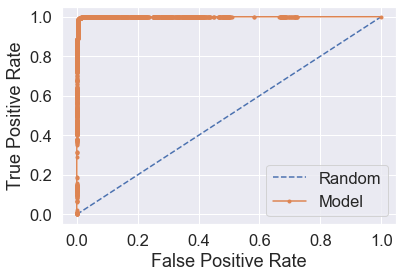

Random: ROC AUC=0.500
Model: ROC AUC=0.999


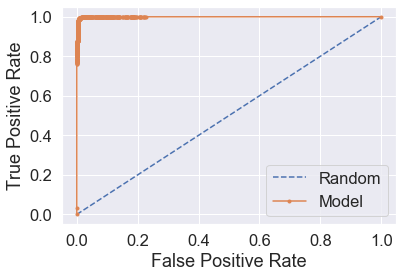

Random: ROC AUC=0.500
Model: ROC AUC=0.999


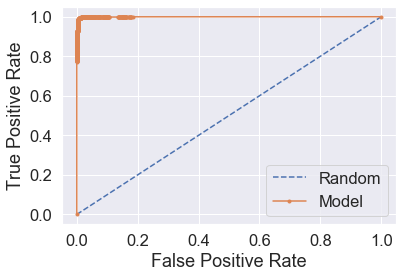

In [67]:
ev.plot_ROC_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_score_iterative', weight_variable=weight_variable_name) 
ev.plot_ROC_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_h2o_score_fixed', weight_variable=weight_variable_name) 
ev.plot_ROC_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_h2o_score_random', weight_variable=weight_variable_name) 

### Plot RF H2O Precision Recall curve

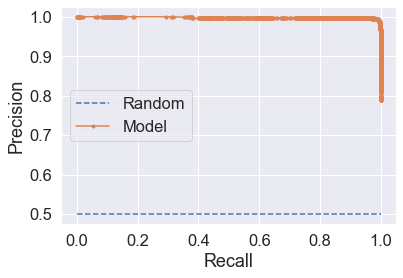

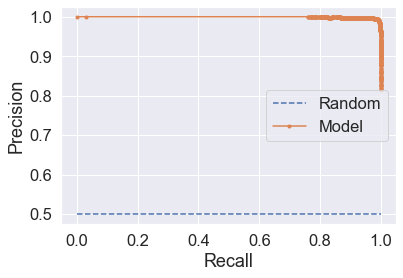

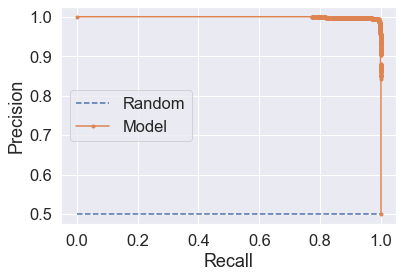

In [68]:
ev.plot_precision_recall_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_score_iterative', 
                            weight_variable=weight_variable_name)
ev.plot_precision_recall_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_h2o_score_fixed', 
                            weight_variable=weight_variable_name)
ev.plot_precision_recall_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_h2o_score_random', 
                            weight_variable=weight_variable_name)  

### Plot RF H2O F1 score, Accuracy, Sensitivity, Specificity, Precision vs Cutoff

..\functions\evaluation.py:561: RuntimeWarning: invalid value encountered in double_scalars
  model_precision = true_positive/(true_positive+false_positive)


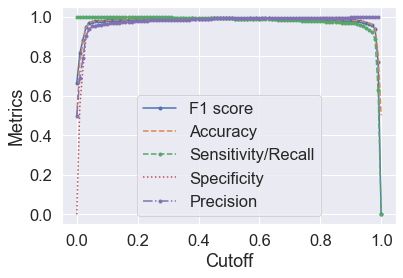

..\functions\evaluation.py:561: RuntimeWarning: invalid value encountered in double_scalars
  model_precision = true_positive/(true_positive+false_positive)


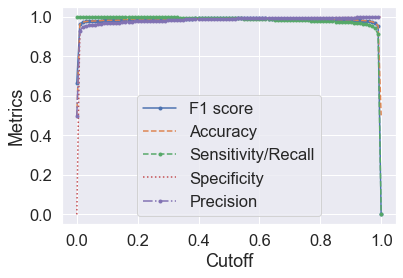

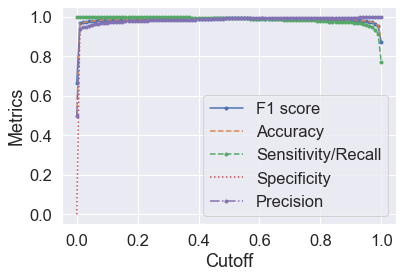

In [69]:
ev.plot_cutoffs(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_score_iterative', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)
ev.plot_cutoffs(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_h2o_score_fixed', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)
ev.plot_cutoffs(table_name=oos, target_variable=target_variable_name, predicted_variable='rf_h2o_score_random', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)

## Save model and export MOJO file

In [70]:
# Save already trained model for future use
model_path=h2o.save_model(model=rf_h2o_fixed, path='{}/output/rf_h2o_grid_model'.format(input_data_path), force=True)

In [71]:
# Save mojo file, which helps deploy the train model
rf_h2o_fixed.download_mojo(path='{}/output/model.zip'.format(input_data_path))

'C:\\Users\\creep\\Anaconda\\Python_Machine_Learning_Suite\\data\\output\\model.zip'

In [72]:
h2o.cluster().shutdown()

H2O session _sid_94c5 closed.


# Gradient Boosting Machine

## Feature selection GBM

In [73]:
# Provide input data to feature selection class
select = fs.SelectBest_weight(df=dev, target=target_variable_name, weight=weight_variable_name)

In [74]:
# Select top features to apply a first screening
from sklearn.ensemble import GradientBoostingClassifier
model_gbm = GradientBoostingClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=1234)
gbm_importance, feats_best_gbm = select.top_gbm_feat(feats=keep_gini_vars, model=model_gbm, n=15)
print('The top GBM features are: \n', feats_best_gbm)
gbm_importance

The top GBM features are: 
 ['numeric7', 'numeric6', 'numeric8', 'numeric4', 'numeric2', 'numeric1', 'character2_nan', 'character1_6', 'character2_1.0', 'character6_5', 'character6_13', 'character6_9', 'character2_7.0', 'character6_3', 'character6_23']


[('numeric7', 0.953846282063749),
 ('numeric6', 0.02608559218256045),
 ('numeric8', 0.007460205337616407),
 ('numeric4', 0.006220416236862502),
 ('numeric2', 0.004056580838202071),
 ('numeric1', 0.0022778061357704104),
 ('character2_nan', 5.311720523931279e-05),
 ('character1_6', 0.0),
 ('character2_1.0', 0.0),
 ('character6_5', 0.0),
 ('character6_13', 0.0),
 ('character6_9', 0.0),
 ('character2_7.0', 0.0),
 ('character6_3', 0.0),
 ('character6_23', 0.0),
 ('character6_17', 0.0),
 ('character6_22', 0.0),
 ('character2_0.0', 0.0),
 ('character6_10', 0.0),
 ('character1_12', 0.0),
 ('character2_5.0', 0.0),
 ('character6_7', 0.0),
 ('character1_4', 0.0),
 ('character2_9.0', 0.0),
 ('character1_5', 0.0),
 ('character6_12', 0.0),
 ('character1_9', 0.0),
 ('character6_19', 0.0),
 ('character1_8', 0.0),
 ('character2_11.0', 0.0),
 ('character1_0', 0.0),
 ('character2_6.0', 0.0),
 ('character6_11', 0.0),
 ('character6_16', 0.0),
 ('character6_4', 0.0),
 ('character6_18', 0.0),
 ('character1_1

In [75]:
import timeit
start = timeit.default_timer()

# Backward selection with gradient boosting machine model: In each step a feature is selected to remove - this removal maximizes Gini
feats_best_gbm_back = select.backward_recur(feats=feats_best_gbm, oos=oos, model=model_gbm, min_feats=10, classification=True)
print(feats_best_gbm_back)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
# Execution time in seconds:  176.60142659999997

step i = 1 feature removed: numeric1 gini: 0.9979266050945832
step i = 2 feature removed: numeric2 gini: 0.99819376657414
step i = 3 feature removed: numeric6 gini: 0.9982708657023094
step i = 4 feature removed: character2_1.0 gini: 0.9982703862078153
step i = 5 feature removed: character6_13 gini: 0.9982740133726502
['numeric7', 'numeric8', 'numeric4', 'character2_nan', 'character1_6', 'character6_5', 'character6_9', 'character2_7.0', 'character6_3', 'character6_23']
Execution time in seconds:  158.0249603000001


## Grid search and train GBM machine learning model

### Grid search based on iterative step search

In [76]:
# Hyperparameter tuning: The process works as follows:
# 1) Iterate n_estimators (grid) for the fixed values of max_depth, max_features, and learning_rate (params). Select the value of n_estimators that minimizes the loss function. 
# 2) Keep the n_estimators value from the previous step. Iterate max_depth (grid) for the fixed value of max_features, learning_rate (params). Select the value of max_depth that minimizes the loss function. 
# 3) Keep the max_depth value from the previous step. Iterate max_features (grid) for the fixed value of learning_rate (params). Select the value of max_features that minimizes the loss function. 
# 4) Keep the max_features value from the previous step. Iterate learning_rate (grid). Select the value of learning_rate that minimizes the loss function. 
import timeit
start = timeit.default_timer()

# 40 models in total
grid = {'n_estimators':[10, 20, 50, 100, 200], # Number of trees, 100-500 is usually sufficient
       'max_depth':[2, 5, 10], # Depth of the tree, 5-6 is usually default
        "max_features":["log2","sqrt"], # Number of variables randomly sampled as candidates at each split, sqrt(p) is usually the default
#       'max_features':[*range(1,len(feats_best_gbm_back),math.ceil(len(feats_best_gbm_back)/5))], \
       'learning_rate':[0.05, 0.1, 0.2, 0.5], # Learing rate. Shrinkage is used for reducing, or shrinking, the impact of each additional fitted 
# base-learner (tree). It reduces the size of incremental steps and thus penalizes the importance of each consecutive iteration. 
# The intuition behind this technique is that it is better to improve a model by taking many small steps than by taking fewer large steps. 
# If one of the boosting iterations turns out to be erroneous, its negative impact can be easily corrected in subsequent steps. 
# High learn rates and especially values close to 1.0 typically result in overfit models with poor performance. 
# Values much smaller than .01 significantly slow down the learning process and might be reserved for overnight runs. 0.10 default
        "min_samples_leaf": np.linspace(0.01, 0.4, 10), # Minimum number of observations in each leaf, 10 is usually default
        "min_samples_split": np.linspace(0.01, 0.4, 10), # The minimum number of observations required to split an internal node
        # If int then min_samples_split is the minimum number of observations
        # If float then then minimum number of observations is a fraction and ceil(min_samples_split * n_samples) 
        "subsample":[0.5, 0.7, 0.8, 0.9, 0.95, 1.0], # The fraction of samples from n_estimators
        "criterion": ["friedman_mse",  "mae"] # The function to measure the quality of a split
#        , "loss":["deviance"]      
       }

params = {'n_estimators': 100, 'max_depth':4, 'max_features':"sqrt", 'learning_rate':0.1, "min_samples_leaf":0.2, "min_samples_split": 0.2, \
         "subsample":0.8, "criterion":"friedman_mse"
         # , "loss":["deviance"]
         }            

opt_params_iterative, loss = mb.step_search_weight(estimator=GradientBoostingClassifier, params=params, grid=grid, target=target_variable_name, 
                                  weight=weight_variable_name, dev=dev, val=oos, keep=feats_best_gbm_back)
print('\n Best Parameters')
print(opt_params_iterative)
print(loss)

# Load GBM algorithm
from sklearn.ensemble import GradientBoostingClassifier

# Define the GBM model
gbm = GradientBoostingClassifier(n_estimators=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='n_estimators'][0], 
                                 max_depth=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='max_depth'][0], 
                                 max_features=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='max_features'][0], 
                                 learning_rate=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='learning_rate'][0], 
                                 min_samples_leaf=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='min_samples_leaf'][0], 
                                 min_samples_split=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='min_samples_split'][0], 
                                 subsample=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='subsample'][0], 
                                 criterion=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='criterion'][0],                                 
                                 random_state=0)

# Train the model
gbm_model = mb.fit_model_weight(dev, feats_best_gbm_back, target_variable_name, weight_variable_name, gbm, 'gbm_iterative.pkl')

# Compute the score for the OOT data
oos['gbm_score_iterative'] = gbm_model.predict_proba(oos[feats_best_gbm_back].values)[:, 1]

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  52.360631900000044

Search Progress:
{'n_estimators': 10, 'max_depth': 4, 'max_features': 'sqrt', 'learning_rate': 0.1, 'min_samples_leaf': 0.2, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} n_estimators 10 0.37696254559422265 0.37696254559422265
{'n_estimators': 20, 'max_depth': 4, 'max_features': 'sqrt', 'learning_rate': 0.1, 'min_samples_leaf': 0.2, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} n_estimators 20 0.20701161170144938 0.20701161170144938
{'n_estimators': 50, 'max_depth': 4, 'max_features': 'sqrt', 'learning_rate': 0.1, 'min_samples_leaf': 0.2, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} n_estimators 50 0.0811376444859094 0.0811376444859094
{'n_estimators': 100, 'max_depth': 4, 'max_features': 'sqrt', 'learning_rate': 0.1, 'min_samples_leaf': 0.2, 'min_samples_split': 0.2, 'subsample': 0.8, 'criterion': 'friedman_mse'} n_estimators 100 0.04201025103214866 0.04201025103214866
{'n_estimators': 200, 'max_depth': 

### Grid search based on RandomizedSearchCV - also uses cross-validation

Execution time in seconds:  114.91307720000009
The best hyperparameter set is: {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 0.3, 'min_samples_leaf': 0.01, 'max_features': 'sqrt', 'max_depth': 4, 'learning_rate': 0.2, 'criterion': 'friedman_mse'}
Mean loss function for cross-validation test data:  0.028847111968769927
Standard deviation loss function for cross-validation test data:  0.0008426680685010186


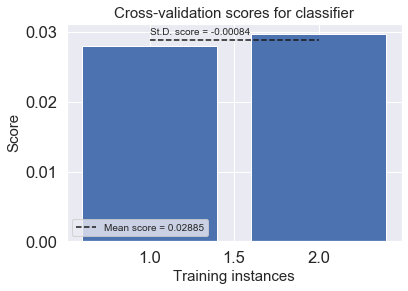

In [77]:
import timeit
start = timeit.default_timer()

# 720 models in total
grid = {'n_estimators':[100, 200, 300, 400, 500], # Number of trees, 100-500 is usually sufficient
       'max_depth':[1, 2, 4, 6], # Depth of the tree, 5-6 is usually default
        "max_features":["sqrt", 'log2', 'auto'], # Number of variables randomly sampled as candidates at each split, sqrt(p) is usually the default
#       'max_features':[*range(1,len(feats_best_gbm_back),math.ceil(len(feats_best_gbm_back)/5))], \
       'learning_rate':[0.1, 0.2, 0.3], # Learing rate. Shrinkage is used for reducing, or shrinking, the impact of each additional fitted 
# base-learner (tree). It reduces the size of incremental steps and thus penalizes the importance of each consecutive iteration. 
# The intuition behind this technique is that it is better to improve a model by taking many small steps than by taking fewer large steps. 
# If one of the boosting iterations turns out to be erroneous, its negative impact can be easily corrected in subsequent steps. 
# High learn rates and especially values close to 1.0 typically result in overfit models with poor performance. 
# Values much smaller than .01 significantly slow down the learning process and might be reserved for overnight runs. 0.10 default
        "min_samples_leaf": [0.01, 0.05, 0.10, 0.15], # Minimum number of observations in each leaf, 10 is usually default
        "min_samples_split": [0.1, 0.2, 0.3], # The minimum number of observations required to split an internal node
        # If int then min_samples_split is the minimum number of observations
        # If float then then minimum number of observations is a fraction and ceil(min_samples_split * n_samples) 
        "subsample":[0.8], # The fraction of samples from n_estimators
        "criterion": ["friedman_mse"] # The function to measure the quality of a split
#        , "loss":["deviance"]      
       }

gbm_grid_random_search_model = mb.grid_search_cv(
    n_splits = 2, # Number of cross-validation splits
    classifier = GradientBoostingClassifier, # Classifier name, e.g. RandomForestClassifier
    keras_function = None, # Define Keras function. If Keras is not used, then leave this parameter blank
    grid_params = grid, # Grid space
    dev_df = dev,  # Development sample that this will analysis will be performed
    feats = feats_best_gbm_back, # List of predictor names
    target = target_variable_name, # Target variable name
    weight_variable = weight_variable_name, # Weight variable name
    randomized_search = True, # Set to True if randomized grid search will be performed, or to False if exhaustive grid search will be performed
    n_random_grids = 100, # Number of grid searches when randomized_search=True. If randomized_search=False, then this parameter is not applicable
    random_state = None, # If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.
    n_jobs = 8 # Number of jobs to run in parallel
)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  131.4532392000001

# Save the best parameters
opt_params_random = gbm_grid_random_search_model.best_params_
print('The best hyperparameter set is:', opt_params_random)
print('Mean loss function for cross-validation test data: ', -gbm_grid_random_search_model.cv_results_['mean_test_score'][gbm_grid_random_search_model.best_index_])
print('Standard deviation loss function for cross-validation test data: ', gbm_grid_random_search_model.cv_results_['std_test_score'][gbm_grid_random_search_model.best_index_])
#print('Mean Gini for OOT data', 2*gbm_grid_random_search_model.score(oos[feats_best_gbm_back], oos[target_variable_name], sample_weight=oos[weight_variable_name])-1)

ev.plot_cross_validation_score(model=gbm_grid_random_search_model)

# Compute the score for the OOT data
oos['gbm_score_random'] = gbm_grid_random_search_model.predict_proba(oos[feats_best_gbm_back].values)[:,1]

### Grid search based on GridSearchCV - also uses cross-validation

Execution time in seconds:  52.406358400000045
The best hyperparameter set is: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.2, 'n_estimators': 200, 'subsample': 0.8}
Mean loss function for cross-validation test data:  0.028304625146510644
Standard deviation loss function for cross-validation test data:  0.0023904746415890667


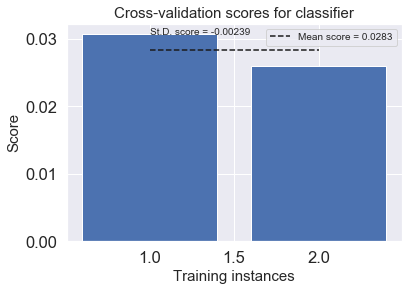

In [78]:
import timeit
start = timeit.default_timer()

from sklearn.model_selection import GridSearchCV

# 81 models in total
grid = {'n_estimators':[100, 200, 300], # Number of trees, 100-500 is usually sufficient
       'max_depth':[2, 4, 6], # Depth of the tree, 5-6 is usually default
        "max_features":["sqrt"], # Number of variables randomly sampled as candidates at each split, sqrt(p) is usually the default
#       'max_features':[*range(1,len(feats_best_gbm_back),math.ceil(len(feats_best_gbm_back)/5))], \
       'learning_rate':[0.1, 0.2, 0.3], # Learing rate. Shrinkage is used for reducing, or shrinking, the impact of each additional fitted 
# base-learner (tree). It reduces the size of incremental steps and thus penalizes the importance of each consecutive iteration. 
# The intuition behind this technique is that it is better to improve a model by taking many small steps than by taking fewer large steps. 
# If one of the boosting iterations turns out to be erroneous, its negative impact can be easily corrected in subsequent steps. 
# High learn rates and especially values close to 1.0 typically result in overfit models with poor performance. 
# Values much smaller than .01 significantly slow down the learning process and might be reserved for overnight runs. 0.10 default
        "min_samples_leaf": [0.05, 0.10, 0.15], # Minimum number of observations in each leaf, 10 is usually default
        "min_samples_split": [0.2], # The minimum number of observations required to split an internal node
        # If int then min_samples_split is the minimum number of observations
        # If float then then minimum number of observations is a fraction and ceil(min_samples_split * n_samples) 
        "subsample":[0.8], # The fraction of samples from n_estimators
        "criterion": ["friedman_mse"] # The function to measure the quality of a split
#        , "loss":["deviance"]      
       }

gbm_grid_fixed_search_model = mb.grid_search_cv(
    n_splits = 2, # Number of cross-validation splits
    classifier = GradientBoostingClassifier, # Classifier name, e.g. RandomForestClassifier
    keras_function = None, # Define Keras function. If Keras is not used, then leave this parameter blank
    grid_params = grid, # Grid space
    dev_df = dev,  # Development sample that this will analysis will be performed
    feats = feats_best_gbm_back, # List of predictor names
    target = target_variable_name, # Target variable name
    weight_variable = weight_variable_name, # Weight variable name
    randomized_search = False, # Set to True if randomized grid search will be performed, or to False if exhaustive grid search will be performed
    n_random_grids = 1, # Number of grid searches when randomized_search=True. If randomized_search=False, then this parameter is not applicable
    random_state = None, # If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.
    n_jobs = 8 # Number of jobs to run in parallel
)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  61.786609

# Save the best parameters
opt_params_fixed = gbm_grid_fixed_search_model.best_params_
print('The best hyperparameter set is:', opt_params_fixed)
print('Mean loss function for cross-validation test data: ', -gbm_grid_fixed_search_model.cv_results_['mean_test_score'][gbm_grid_fixed_search_model.best_index_])
print('Standard deviation loss function for cross-validation test data: ', gbm_grid_fixed_search_model.cv_results_['std_test_score'][gbm_grid_fixed_search_model.best_index_])
#print('Mean Gini for OOT data', 2*gbm_grid_fixed_search_model.score(oos[feats_best_gbm_back], oos[target_variable_name], sample_weight=oos[weight_variable_name])-1)

ev.plot_cross_validation_score(model=gbm_grid_fixed_search_model)

# Compute the score for the OOT data
oos['gbm_score_fixed'] = gbm_grid_fixed_search_model.predict_proba(oos[feats_best_gbm_back].values)[:, 1]

## Calculate GBM feature importance

In [79]:
# Load GBM algorithm
from sklearn.ensemble import GradientBoostingClassifier

# Define the GBM model
opt_params = opt_params_random
gbm = GradientBoostingClassifier(n_estimators=[x[1] for x in list(opt_params.items()) if x[0]=='n_estimators'][0], 
                                 max_depth=[x[1] for x in list(opt_params.items()) if x[0]=='max_depth'][0], 
                                 max_features=[x[1] for x in list(opt_params.items()) if x[0]=='max_features'][0], 
                                 learning_rate=[x[1] for x in list(opt_params.items()) if x[0]=='learning_rate'][0], 
                                 min_samples_leaf=[x[1] for x in list(opt_params.items()) if x[0]=='min_samples_leaf'][0], 
                                 min_samples_split=[x[1] for x in list(opt_params.items()) if x[0]=='min_samples_split'][0], 
                                 subsample=[x[1] for x in list(opt_params.items()) if x[0]=='subsample'][0], 
                                 criterion=[x[1] for x in list(opt_params.items()) if x[0]=='criterion'][0],                                 
                                 random_state=0)

# Train the model
gbm_model = mb.fit_model_weight(dev, feats_best_gbm_back, target_variable_name, weight_variable_name, gbm, 'gbm.pkl')

# Calculate feature importance
feat_imprtnce_dictnry_gbm = mb.feature_imp(gbm_model, feats_best_gbm_back)
for key, value in sorted(feat_imprtnce_dictnry_gbm.items(), key=lambda item: item[1], reverse=True):
    print("%s: %s" % (key, value))

numeric7: 0.9481352102825936
numeric8: 0.04917457965346176
numeric4: 0.0026902100639445425
character2_nan: 0.0
character1_6: 0.0
character6_5: 0.0
character6_9: 0.0
character2_7.0: 0.0
character6_3: 0.0
character6_23: 0.0


## Calculate GBM log-loss

In [80]:
from sklearn.metrics import log_loss
print ("log-loss_iterative")
print(log_loss(y_true=oos[target_variable_name].values, y_pred=oos['gbm_score_iterative'].values, sample_weight=oos[weight_variable_name].values, eps=1e-15))
print ("log-loss_fixed")
print(log_loss(y_true=oos[target_variable_name].values, y_pred=oos['gbm_score_fixed'].values, sample_weight=oos[weight_variable_name].values, eps=1e-15))
print ("log-loss_random")
print(log_loss(y_true=oos[target_variable_name].values, y_pred=oos['gbm_score_random'].values, sample_weight=oos[weight_variable_name].values, eps=1e-15))

log-loss_iterative
0.027573123832728703
log-loss_fixed
0.02878571956700073
log-loss_random
0.028401097721253838


## Calculate GBM Precision/Recall Area Under the Curve

In [81]:
print ("precision_recall_auc_iterative")
print(ev.auc_precision_recall(table_name=oos, target_variable=target_variable_name, predicted_variable='gbm_score_iterative', 
                            weight_variable=weight_variable_name))
print ("precision_recall_auc_fixed")
print(ev.auc_precision_recall(table_name=oos, target_variable=target_variable_name, predicted_variable='gbm_score_fixed', 
                            weight_variable=weight_variable_name))
print ("precision_recall_auc_random")
print(ev.auc_precision_recall(table_name=oos, target_variable=target_variable_name, predicted_variable='gbm_score_random', 
                            weight_variable=weight_variable_name))

precision_recall_auc_iterative
0.9993425644370453
precision_recall_auc_fixed
0.9991842009626116
precision_recall_auc_random
0.9993111771340185


## Calculate GBM Gini, for the top population

In [82]:
print ("unit_gini_iterative")
print(ev.calculate_gini(
    table_name=oos, # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='gbm_score_iterative', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))
print ("unit_gini_fixed")
print(ev.calculate_gini(
    table_name=oos, # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='gbm_score_fixed', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))
print ("unit_gini_random")
print(ev.calculate_gini(
    table_name=oos, # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='gbm_score_random', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))

unit_gini_iterative
0.9986859223650884
unit_gini_fixed
0.9983924889686304
unit_gini_random
0.9986074699467775


## Calculate GBM Lifting table

In [83]:
lt_gbm_iterative = ev.lift_table_weight(oos[['gbm_score_iterative', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_gbm_fixed = ev.lift_table_weight(oos[['gbm_score_fixed', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_gbm_random = ev.lift_table_weight(oos[['gbm_score_random', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_gbm_fixed

,Quantile Unit,# Cases,# Responses,Cumulative # Responses,% Response,FPR,Cumulative FPR,ADR,Cumulative ADR,Lift,Cumulative Lift,Quantile Value,Value,Cumulative Value,VDR,Cumulative VDR
0,0.1,456.402,456.402,456.402,1.000,0.000000e+00,0.000,0.200,0.200,2.005,2.005,0.1,4482952.126,4.482952e+06,0.198,0.198
1,0.2,456.279,456.279,912.681,1.000,0.000000e+00,0.000,0.200,0.401,2.005,2.005,0.2,4586463.624,9.069416e+06,0.203,0.402
2,0.3,456.135,456.135,1368.816,1.000,0.000000e+00,0.000,0.200,0.601,2.005,2.005,0.3,4559341.438,1.362876e+07,0.202,0.603
3,0.4,456.202,455.196,1824.012,0.998,2.000000e-03,0.001,0.200,0.801,2.000,2.004,0.4,4432094.615,1.806085e+07,0.196,0.800
4,0.5,456.729,434.573,2258.585,0.951,5.100000e-02,0.010,0.191,0.992,1.907,1.984,0.5,4335723.990,2.239658e+07,0.192,0.992
5,0.6,455.772,17.930,2276.515,0.039,2.441900e+01,0.203,0.008,1.000,0.079,1.667,0.6,179510.564,2.257609e+07,0.008,1.000
6,0.7,456.000,0.650,2277.165,0.001,7.004120e+02,0.402,0.000,1.000,0.003,1.429,0.7,9181.278,2.258527e+07,0.000,1.000
7,0.8,457.996,0.000,2277.165,0.000,1.000000e+09,0.604,0.000,1.000,0.000,1.250,0.8,0.000,2.258527e+07,0.000,1.000
8,0.9,455.525,0.000,2277.165,0.000,1.000000e+09,0.804,0.000,1.000,0.000,1.112,0.9,0.000,2.258527e+07,0.000,1.000
9,1.0,458.024,0.000,2277.165,0.000,1.000000e+09,1.005,0.000,1.000,0.000,1.000,1.0,0.000,2.258527e+07,0.000,1.000


## Plots GBM

### Plot GBM Detection rate vs. Population Distribution

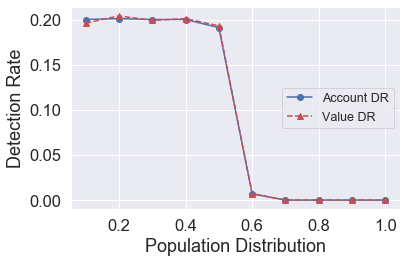

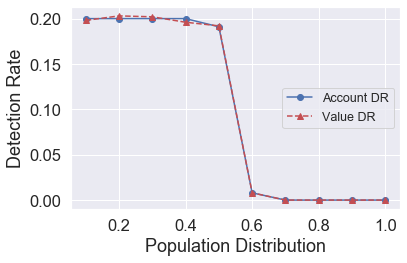

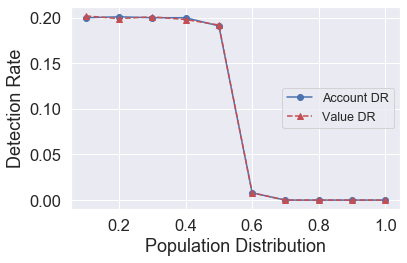

In [84]:
ev.plot_ADR_Quantile(lt_gbm_iterative)
ev.plot_ADR_Quantile(lt_gbm_fixed)
ev.plot_ADR_Quantile(lt_gbm_random)

### Plot GBM Cum. Detection rate vs. Population Distribution (Gains chart)

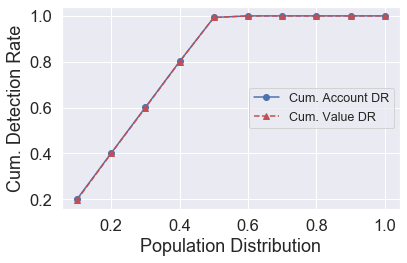

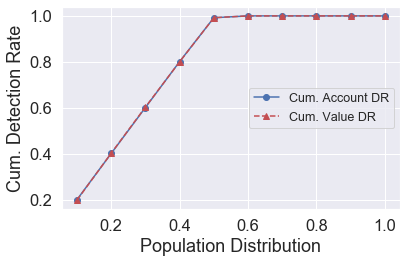

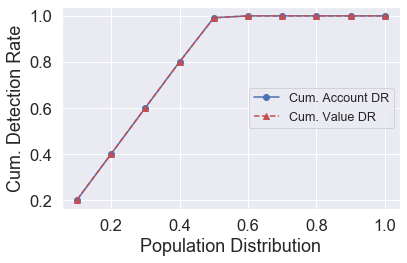

In [85]:
ev.plot_cADR_Quantile(lt_gbm_iterative)
ev.plot_cADR_Quantile(lt_gbm_fixed)
ev.plot_cADR_Quantile(lt_gbm_random)

### Plot GBM FPR vs. Population Distribution

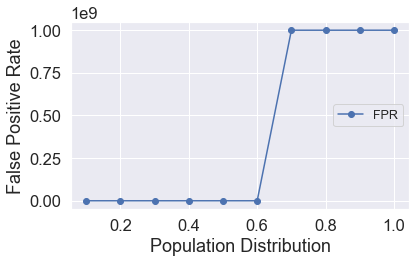

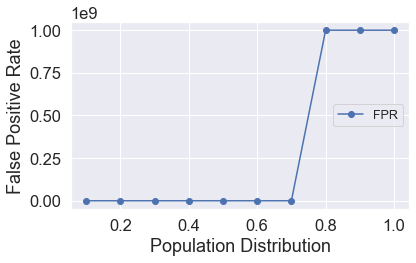

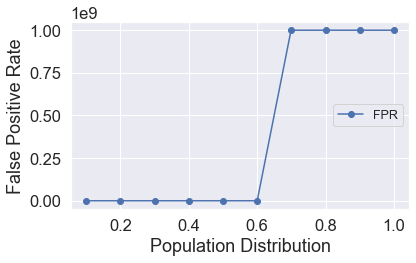

In [86]:
ev.plot_FPR_Quantile(lt_gbm_iterative)
ev.plot_FPR_Quantile(lt_gbm_fixed)
ev.plot_FPR_Quantile(lt_gbm_random)

### Plot GBM Cum. FPR vs. Population Distribution

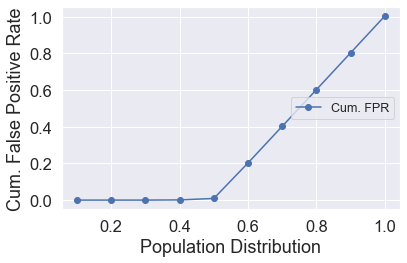

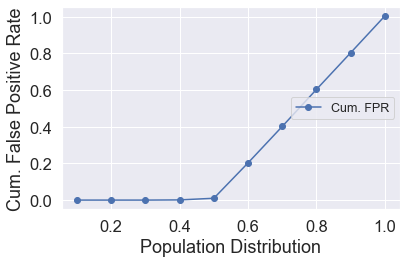

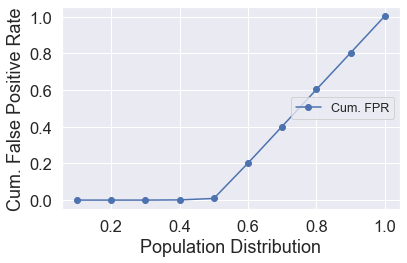

In [87]:
ev.plot_cFPR_Quantile(lt_gbm_iterative)
ev.plot_cFPR_Quantile(lt_gbm_fixed)
ev.plot_cFPR_Quantile(lt_gbm_random)

### Plot GBM ROC curve

Random: ROC AUC=0.500
Model: ROC AUC=0.999


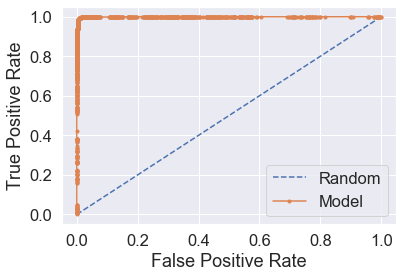

Random: ROC AUC=0.500
Model: ROC AUC=0.999


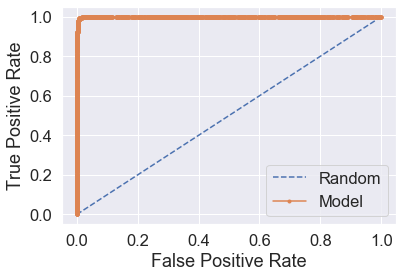

Random: ROC AUC=0.500
Model: ROC AUC=0.999


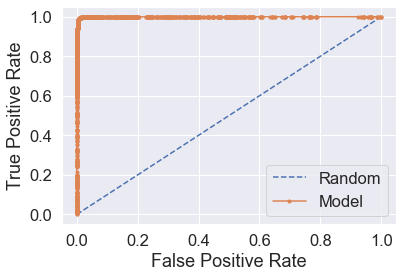

In [88]:
ev.plot_ROC_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='gbm_score_iterative', weight_variable=weight_variable_name) 
ev.plot_ROC_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='gbm_score_fixed', weight_variable=weight_variable_name) 
ev.plot_ROC_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='gbm_score_random', weight_variable=weight_variable_name) 

### Plot GBM Precision Recall curve

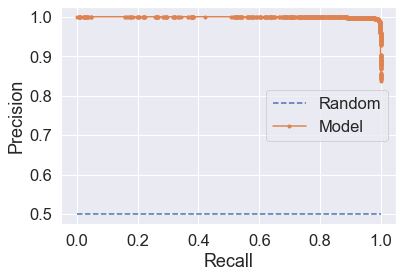

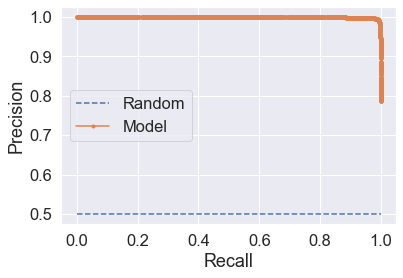

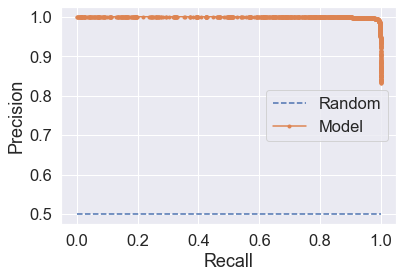

In [89]:
ev.plot_precision_recall_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='gbm_score_iterative', 
                            weight_variable=weight_variable_name)
ev.plot_precision_recall_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='gbm_score_fixed', 
                            weight_variable=weight_variable_name)
ev.plot_precision_recall_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='gbm_score_random', 
                            weight_variable=weight_variable_name)  

### Plot GBM F1 score, Accuracy, Sensitivity, Specificity, Precision vs Cutoff

..\functions\evaluation.py:561: RuntimeWarning: invalid value encountered in double_scalars
  model_precision = true_positive/(true_positive+false_positive)


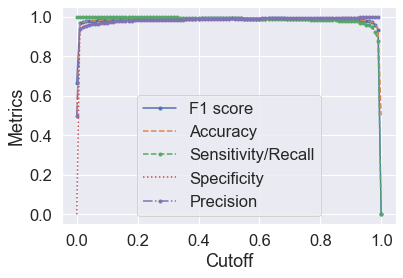

..\functions\evaluation.py:561: RuntimeWarning: invalid value encountered in double_scalars
  model_precision = true_positive/(true_positive+false_positive)


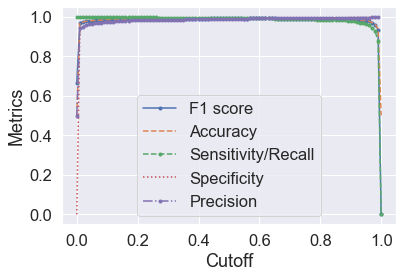

..\functions\evaluation.py:561: RuntimeWarning: invalid value encountered in double_scalars
  model_precision = true_positive/(true_positive+false_positive)


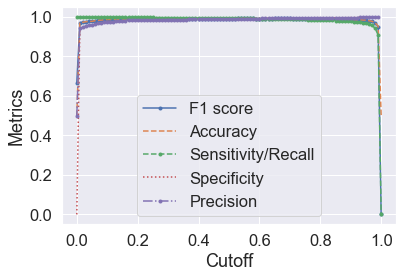

In [90]:
ev.plot_cutoffs(table_name=oos, target_variable=target_variable_name, predicted_variable='gbm_score_iterative', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)
ev.plot_cutoffs(table_name=oos, target_variable=target_variable_name, predicted_variable='gbm_score_fixed', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)
ev.plot_cutoffs(table_name=oos, target_variable=target_variable_name, predicted_variable='gbm_score_random', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)

# Light Gradient Boosting Machine

## Feature selection lightGBM

In [91]:
# Provide input data to feature selection class
select = fs.SelectBest_weight(df=dev, target=target_variable_name, weight=weight_variable_name)

In [92]:
# Select top features to apply a first screening
from lightgbm import LGBMClassifier
model_lgbm = LGBMClassifier(boosting_type='gbdt',  objective='binary', n_estimators=200, learning_rate=0.1, max_depth=5, random_state=1234, n_jobs=6)
lgbm_importance, feats_best_lgbm = select.top_lgbm_feat(feats=keep_gini_vars, model=model_lgbm, n=15)
print('The top lightGBM features are: \n', feats_best_lgbm)
lgbm_importance

The top lightGBM features are: 
 ['numeric7', 'numeric6', 'numeric4', 'numeric8', 'numeric2', 'numeric1', 'character2_nan', 'character1_6', 'character2_1.0', 'character6_5', 'character6_13', 'character6_9', 'character2_7.0', 'character6_3', 'character6_23']


[('numeric7', 860),
 ('numeric6', 737),
 ('numeric4', 707),
 ('numeric8', 540),
 ('numeric2', 458),
 ('numeric1', 394),
 ('character2_nan', 7),
 ('character1_6', 0),
 ('character2_1.0', 0),
 ('character6_5', 0),
 ('character6_13', 0),
 ('character6_9', 0),
 ('character2_7.0', 0),
 ('character6_3', 0),
 ('character6_23', 0),
 ('character6_17', 0),
 ('character6_22', 0),
 ('character2_0.0', 0),
 ('character6_10', 0),
 ('character1_12', 0),
 ('character2_5.0', 0),
 ('character6_7', 0),
 ('character1_4', 0),
 ('character2_9.0', 0),
 ('character1_5', 0),
 ('character6_12', 0),
 ('character1_9', 0),
 ('character6_19', 0),
 ('character1_8', 0),
 ('character2_11.0', 0),
 ('character1_0', 0),
 ('character2_6.0', 0),
 ('character6_11', 0),
 ('character6_16', 0),
 ('character6_4', 0),
 ('character6_18', 0),
 ('character1_10', 0),
 ('character6_2', 0),
 ('character1_3', 0),
 ('character2_2.0', 0),
 ('character6_8', 0),
 ('character1_2', 0),
 ('character2_3.0', 0),
 ('character6_15', 0),
 ('charact

In [93]:
import timeit
start = timeit.default_timer()

# Backward selection with lightGBM model: In each step a feature is selected to remove - this removal maximizes Gini
feats_best_lgbm_back = select.backward_recur(feats=feats_best_lgbm, oos=oos, model=model_lgbm, min_feats=10, classification=True)
print(feats_best_lgbm_back)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
# Execution time in seconds:  11.858331700000008

step i = 1 feature removed: numeric2 gini: 0.9983762701591252
step i = 2 feature removed: character1_6 gini: 0.9983762701591252
step i = 3 feature removed: character2_1.0 gini: 0.9983762701591252
step i = 4 feature removed: character6_5 gini: 0.9983762701591252
step i = 5 feature removed: character6_13 gini: 0.9983762701591252
['numeric7', 'numeric6', 'numeric4', 'numeric8', 'numeric1', 'character2_nan', 'character6_9', 'character2_7.0', 'character6_3', 'character6_23']
Execution time in seconds:  12.386034700000096


## Grid search and train lightGBM machine learning model

### Grid search based on iterative step search

In [94]:
# Hyperparameter tuning: The process works as follows:
# 1) Iterate n_estimators (grid) for the fixed values of max_depth, learning_rate, etc (params). Select the value of n_estimators that minimizes the loss function. 
# 2) Keep the n_estimators value from the previous step. Iterate max_depth (grid) for the fixed value of learning_rate, etc (params). Select the value of max_depth that minimizes the loss function. 
# 3) Keep the max_depth value from the previous step. Iterate learning_rate (grid) for the fixed value of the remaining parameters (params). Select the value of max_features that minimizes the loss function. 
# 4) ...
import timeit
start = timeit.default_timer()

import math
# 38 models in total
grid = {'n_estimators':[10, 20, 50, 100, 200], # Number of trees, 100-500 is usually sufficient
       'max_depth':[2, 5, 10], # Depth of the tree, 5-6 is usually default
       'learning_rate':[0.05, 0.1, 0.2, 0.5], # Learing rate. Shrinkage is used for reducing, or shrinking, the impact of each additional fitted 
# base-learner (tree). It reduces the size of incremental steps and thus penalizes the importance of each consecutive iteration. 
# The intuition behind this technique is that it is better to improve a model by taking many small steps than by taking fewer large steps. 
# If one of the boosting iterations turns out to be erroneous, its negative impact can be easily corrected in subsequent steps. 
# High learn rates and especially values close to 1.0 typically result in overfit models with poor performance. 
# Values much smaller than .01 significantly slow down the learning process and might be reserved for overnight runs. 0.10 default
        'min_child_samples': [10, 100, 500, 1000, 2000, 5000], # Minimum number of observations in each leaf, 10 is usually default
        'subsample': [0.5, 0.7, 0.8, 0.9, 0.95, 1.0], # The fraction of samples from n_estimators
        'colsample_bytree': np.linspace(0.01, 0.4, 10), # Subsample ratio of columns when constructing each tree
        'eval_metric': ['l2', 'l1', 'logloss', 'ndcg'], # If string, it should be a built-in evaluation metric to use
        'boosting_type': ['gbdt', 'dart', 'goss'], # ‘gbdt’, traditional Gradient Boosting Decision Tree. ‘dart’, Dropouts meet Multiple Additive Regression Trees. ‘goss’, Gradient-based One-Side Sampling. ‘rf’, Random Forest
        'num_leaves': [10, 20, 30, 50], # Maximum number of tree leaves 
        'bagging_fraction': [0.5, 0.7, 0.8, 0.9, 0.95, 1.0], # The fraction of observations to be used for each iteration
        'reg_alpha': [0.1, 0.5], # L1 regularization term on weights
        'reg_lambda': [0.1, 0.5], # L2 regularization term on weights
        'lambda_l1': [0, 1, 1.5], # L1 regularization
        'lambda_l2': [0, 1], # L2 regularization
        'importance_type': ['split'], # The type of feature importance to be filled into feature_importances_. If ‘split’, result contains numbers of times the feature is used in a model. If ‘gain’, result contains total gains of splits which use the feature.
        'objective': ['binary'] # Specify the learning task and the corresponding learning objective
       }

params = {'n_estimators': 100, 'max_depth':4, 'learning_rate':0.1, 'min_child_samples': 10, 'subsample': 1.0, 
          'colsample_bytree': math.ceil(math.sqrt(len(feats_best_lgbm_back)))/len(feats_best_lgbm_back),  'eval_metric': 'l2', 'boosting_type': 'gbdt',
          'num_leaves': 31, 'bagging_fraction':1, 'reg_alpha': 0, 'reg_lambda': 0, 'lambda_l1': 0, 'lambda_l2': 0,
          'importance_type': 'split', 'objective': 'binary'
         }            

opt_params_iterative, loss = mb.step_search_weight(estimator=LGBMClassifier, params=params, grid=grid, target=target_variable_name, 
                                  weight=weight_variable_name, dev=dev, val=oos, keep=feats_best_lgbm_back)
print('\n Best Parameters')
print(opt_params_iterative)
print(loss)

# Define the lightGBM model
lightgbm_classifier = LGBMClassifier(n_estimators=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='n_estimators'][0], 
                                 max_depth=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='max_depth'][0], 
                                 learning_rate=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='learning_rate'][0], 
                                 min_child_samples=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='min_child_samples'][0], 
                                 subsample=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='subsample'][0], 
                                 colsample_bytree=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='colsample_bytree'][0], 
                                 eval_metric=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='eval_metric'][0], 
                                 boosting_type=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='boosting_type'][0], 
                                 num_leaves=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='num_leaves'][0], 
                                 bagging_fraction=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='bagging_fraction'][0], 
                                 reg_alpha=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='reg_alpha'][0], 
                                 reg_lambda=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='reg_lambda'][0], 
                                 lambda_l1=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='lambda_l1'][0], 
                                 lambda_l2=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='lambda_l2'][0], 
                                 importance_type=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='importance_type'][0], 
                                 objective=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='objective'][0], 
                                 random_state=1234, 
                                 n_jobs=6)

# Train the model
lightgbm_model = mb.fit_model_weight(dev, feats_best_lgbm_back, target_variable_name, weight_variable_name, lightgbm_classifier, 'lgbm_iterative.pkl')

# Compute the score for the OOT data
oos['lightgbm_score_iterative'] = lightgbm_model.predict_proba(oos[feats_best_lgbm_back].values)[:, 1]

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  3.8296081999999387

Search Progress:
{'n_estimators': 10, 'max_depth': 4, 'learning_rate': 0.1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.4, 'eval_metric': 'l2', 'boosting_type': 'gbdt', 'num_leaves': 31, 'bagging_fraction': 1, 'reg_alpha': 0, 'reg_lambda': 0, 'lambda_l1': 0, 'lambda_l2': 0, 'importance_type': 'split', 'objective': 'binary'} n_estimators 10 0.30337344043058595 0.30337344043058595
{'n_estimators': 20, 'max_depth': 4, 'learning_rate': 0.1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.4, 'eval_metric': 'l2', 'boosting_type': 'gbdt', 'num_leaves': 31, 'bagging_fraction': 1, 'reg_alpha': 0, 'reg_lambda': 0, 'lambda_l1': 0, 'lambda_l2': 0, 'importance_type': 'split', 'objective': 'binary'} n_estimators 20 0.2563537742720698 0.2563537742720698
{'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.4, 'eval_metric': 'l2', 'boosting_type': 'gbdt', 'num_leaves': 31, 'bagging_fraction': 1,

{'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.1, 'min_child_samples': 500, 'subsample': 1.0, 'colsample_bytree': 0.4, 'eval_metric': 'l2', 'boosting_type': 'gbdt', 'num_leaves': 31, 'bagging_fraction': 1, 'reg_alpha': 0, 'reg_lambda': 0, 'lambda_l1': 0, 'lambda_l2': 0, 'importance_type': 'split', 'objective': 'binary'} boosting_type goss 0.031960168120664996 0.027591158066460772

{'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.1, 'min_child_samples': 500, 'subsample': 1.0, 'colsample_bytree': 0.4, 'eval_metric': 'l2', 'boosting_type': 'gbdt', 'num_leaves': 31, 'bagging_fraction': 1, 'reg_alpha': 0, 'reg_lambda': 0, 'lambda_l1': 0, 'lambda_l2': 0, 'importance_type': 'split', 'objective': 'binary'} num_leaves 10 0.027591158066460772 0.027591158066460772
{'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.1, 'min_child_samples': 500, 'subsample': 1.0, 'colsample_bytree': 0.4, 'eval_metric': 'l2', 'boosting_type': 'gbdt', 'num_leaves': 31, 'bagging_fraction': 1, 'r

### Grid search based on RandomizedSearchCV - also uses cross-validation

Execution time in seconds:  21.34202270000003
The best hyperparameter set is: {'subsample': 0.95, 'reg_lambda': 0.1, 'reg_alpha': 0, 'objective': 'binary', 'num_leaves': 35, 'n_estimators': 200, 'min_child_samples': 10, 'max_depth': 2, 'learning_rate': 0.1, 'lambda_l2': 0, 'lambda_l1': 1, 'importance_type': 'split', 'eval_metric': 'l2', 'colsample_bytree': 0.2, 'boosting_type': 'gbdt', 'bagging_fraction': 1.0}
Mean loss function for cross-validation test data:  0.030862215210758097
Standard deviation loss function for cross-validation test data:  0.00346460231649357


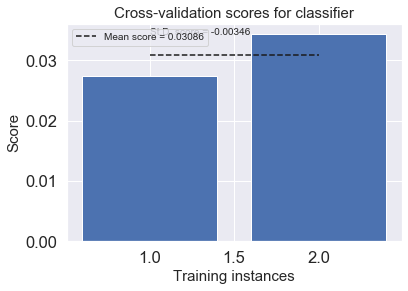

In [95]:
import timeit
start = timeit.default_timer()

# 1,536 models in total
grid = {'n_estimators':[50, 100, 200], # Number of trees, 100-500 is usually sufficient
       'max_depth':[2, 5], # Depth of the tree, 5-6 is usually default
       'learning_rate':[0.1, 0.2], # Learing rate. Shrinkage is used for reducing, or shrinking, the impact of each additional fitted 
# base-learner (tree). It reduces the size of incremental steps and thus penalizes the importance of each consecutive iteration. 
# The intuition behind this technique is that it is better to improve a model by taking many small steps than by taking fewer large steps. 
# If one of the boosting iterations turns out to be erroneous, its negative impact can be easily corrected in subsequent steps. 
# High learn rates and especially values close to 1.0 typically result in overfit models with poor performance. 
# Values much smaller than .01 significantly slow down the learning process and might be reserved for overnight runs. 0.10 default
        'min_child_samples': [10, 100], # Minimum number of observations in each leaf, 10 is usually default
        'subsample': [0.95, 1.0], # The fraction of samples from n_estimators
        'colsample_bytree': np.linspace(0.20, 0.23, 2), # Subsample ratio of columns when constructing each tree
        'eval_metric': ['l2'], # If string, it should be a built-in evaluation metric to use
        'boosting_type': ['gbdt'], # ‘gbdt’, traditional Gradient Boosting Decision Tree. ‘dart’, Dropouts meet Multiple Additive Regression Trees. ‘goss’, Gradient-based One-Side Sampling. ‘rf’, Random Forest
        'num_leaves': [30, 35], # Maximum number of tree leaves 
        'bagging_fraction': [0.95, 1.0], # The fraction of observations to be used for each iteration
        'reg_alpha': [0, 0.1], # L1 regularization term on weights
        'reg_lambda': [0, 0.1], # L2 regularization term on weights
        'lambda_l1': [1], # L1 regularization
        'lambda_l2': [0], # L2 regularization
        'importance_type': ['split'], # The type of feature importance to be filled into feature_importances_. If ‘split’, result contains numbers of times the feature is used in a model. If ‘gain’, result contains total gains of splits which use the feature.
        'objective': ['binary'] # Specify the learning task and the corresponding learning objective
       }

lightgbm_grid_random_search = mb.grid_search_cv(
    n_splits = 2, # Number of cross-validation splits
    classifier = LGBMClassifier, # Classifier name, e.g. RandomForestClassifier
    keras_function = None, # Define Keras function. If Keras is not used, then leave this parameter blank
    grid_params = grid, # Grid space
    dev_df = dev,  # Development sample that this will analysis will be performed
    feats = feats_best_lgbm_back, # List of predictor names
    target = target_variable_name, # Target variable name
    weight_variable = weight_variable_name, # Weight variable name
    randomized_search = True, # Set to True if randomized grid search will be performed, or to False if exhaustive grid search will be performed
    n_random_grids = 100, # Number of grid searches when randomized_search=True. If randomized_search=False, then this parameter is not applicable
    random_state = None, # If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.
    n_jobs = 8 # Number of jobs to run in parallel
)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  6.438787699999921

# Save the best parameters
opt_params_random = lightgbm_grid_random_search.best_params_
print('The best hyperparameter set is:', opt_params_random)
print('Mean loss function for cross-validation test data: ', -lightgbm_grid_random_search.cv_results_['mean_test_score'][lightgbm_grid_random_search.best_index_])
print('Standard deviation loss function for cross-validation test data: ', lightgbm_grid_random_search.cv_results_['std_test_score'][lightgbm_grid_random_search.best_index_])
#print('Mean Gini for OOT data', 2*lightgbm_grid_random_search.score(oos[feats_best_lgbm_back], oos[target_variable_name])-1)

ev.plot_cross_validation_score(model=lightgbm_grid_random_search)

# Compute the score for the OOT data
oos['lightgbm_score_random'] = lightgbm_grid_random_search.predict_proba(oos[feats_best_lgbm_back].values)[:,1]

### Grid search based on GridSearchCV - also uses cross-validation

Execution time in seconds:  157.66077630000007
The best hyperparameter set is: {'bagging_fraction': 0.95, 'boosting_type': 'gbdt', 'colsample_bytree': 0.2, 'eval_metric': 'l2', 'importance_type': 'split', 'lambda_l1': 1, 'lambda_l2': 0, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_samples': 10, 'n_estimators': 200, 'num_leaves': 30, 'objective': 'binary', 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.95}
Mean loss function for cross-validation test data:  0.03130629869413785
Standard deviation loss function for cross-validation test data:  0.0013036902165478523


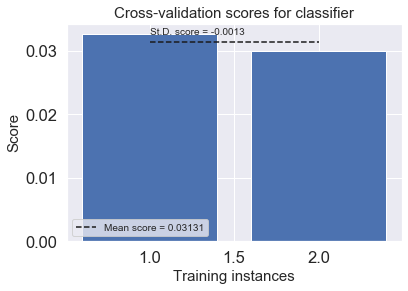

In [96]:
import timeit
start = timeit.default_timer()

# 1,536 models in total
grid = {'n_estimators':[50, 100, 200], # Number of trees, 100-500 is usually sufficient
       'max_depth':[2, 5], # Depth of the tree, 5-6 is usually default
       'learning_rate':[0.1, 0.2], # Learing rate. Shrinkage is used for reducing, or shrinking, the impact of each additional fitted 
# base-learner (tree). It reduces the size of incremental steps and thus penalizes the importance of each consecutive iteration. 
# The intuition behind this technique is that it is better to improve a model by taking many small steps than by taking fewer large steps. 
# If one of the boosting iterations turns out to be erroneous, its negative impact can be easily corrected in subsequent steps. 
# High learn rates and especially values close to 1.0 typically result in overfit models with poor performance. 
# Values much smaller than .01 significantly slow down the learning process and might be reserved for overnight runs. 0.10 default
        'min_child_samples': [10, 100], # Minimum number of observations in each leaf, 10 is usually default
        'subsample': [0.95, 1.0], # The fraction of samples from n_estimators
        'colsample_bytree': np.linspace(0.20, 0.23, 2), # Subsample ratio of columns when constructing each tree
        'eval_metric': ['l2'], # If string, it should be a built-in evaluation metric to use
        'boosting_type': ['gbdt'], # ‘gbdt’, traditional Gradient Boosting Decision Tree. ‘dart’, Dropouts meet Multiple Additive Regression Trees. ‘goss’, Gradient-based One-Side Sampling. ‘rf’, Random Forest
        'num_leaves': [30, 35], # Maximum number of tree leaves 
        'bagging_fraction': [0.95, 1.0], # The fraction of observations to be used for each iteration
        'reg_alpha': [0, 0.1], # L1 regularization term on weights
        'reg_lambda': [0, 0.1], # L2 regularization term on weights
        'lambda_l1': [1], # L1 regularization
        'lambda_l2': [0], # L2 regularization
        'importance_type': ['split'], # The type of feature importance to be filled into feature_importances_. If ‘split’, result contains numbers of times the feature is used in a model. If ‘gain’, result contains total gains of splits which use the feature.
        'objective': ['binary'] # Specify the learning task and the corresponding learning objective
       }

lightgbm_grid_fixed_search = mb.grid_search_cv(
    n_splits = 2, # Number of cross-validation splits
    classifier = LGBMClassifier, # Classifier name, e.g. RandomForestClassifier
    keras_function = None, # Define Keras function. If Keras is not used, then leave this parameter blank
    grid_params = grid, # Grid space
    dev_df = dev,  # Development sample that this will analysis will be performed
    feats = feats_best_lgbm_back, # List of predictor names
    target = target_variable_name, # Target variable name
    weight_variable = weight_variable_name, # Weight variable name
    randomized_search = False, # Set to True if randomized grid search will be performed, or to False if exhaustive grid search will be performed
    n_random_grids = 1, # Number of grid searches when randomized_search=True. If randomized_search=False, then this parameter is not applicable
    random_state = None, # If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.
    n_jobs = 8 # Number of jobs to run in parallel
)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  111.53426379999996

# Save the best parameters
opt_params_fixed = lightgbm_grid_fixed_search.best_params_
print('The best hyperparameter set is:', opt_params_fixed)
print('Mean loss function for cross-validation test data: ', -lightgbm_grid_fixed_search.cv_results_['mean_test_score'][lightgbm_grid_fixed_search.best_index_])
print('Standard deviation loss function for cross-validation test data: ', lightgbm_grid_fixed_search.cv_results_['std_test_score'][lightgbm_grid_fixed_search.best_index_])
#print('Mean Gini for OOT data', 2*lightgbm_grid_fixed_search.score(oos[feats_best_lgbm_back], oos[target_variable_name], sample_weight=oos[weight_variable_name])-1)

ev.plot_cross_validation_score(model=lightgbm_grid_fixed_search)

# Compute the score for the OOT data
oos['lightgbm_score_fixed'] = lightgbm_grid_fixed_search.predict_proba(oos[feats_best_lgbm_back].values)[:, 1]

## Calculate lightGBM feature importance

In [97]:
# Define the lightGBM model
opt_params = opt_params_random
lightgbm_classifier = LGBMClassifier(n_estimators=[x[1] for x in list(opt_params.items()) if x[0]=='n_estimators'][0], 
                                 max_depth=[x[1] for x in list(opt_params.items()) if x[0]=='max_depth'][0], 
                                 learning_rate=[x[1] for x in list(opt_params.items()) if x[0]=='learning_rate'][0], 
                                 min_child_samples=[x[1] for x in list(opt_params.items()) if x[0]=='min_child_samples'][0], 
                                 subsample=[x[1] for x in list(opt_params.items()) if x[0]=='subsample'][0], 
                                 colsample_bytree=[x[1] for x in list(opt_params.items()) if x[0]=='colsample_bytree'][0], 
                                 eval_metric=[x[1] for x in list(opt_params.items()) if x[0]=='eval_metric'][0], 
                                 boosting_type=[x[1] for x in list(opt_params.items()) if x[0]=='boosting_type'][0], 
                                 num_leaves=[x[1] for x in list(opt_params.items()) if x[0]=='num_leaves'][0], 
                                 bagging_fraction=[x[1] for x in list(opt_params.items()) if x[0]=='bagging_fraction'][0], 
                                 reg_alpha=[x[1] for x in list(opt_params.items()) if x[0]=='reg_alpha'][0], 
                                 reg_lambda=[x[1] for x in list(opt_params.items()) if x[0]=='reg_lambda'][0], 
                                 lambda_l1=[x[1] for x in list(opt_params.items()) if x[0]=='lambda_l1'][0], 
                                 lambda_l2=[x[1] for x in list(opt_params.items()) if x[0]=='lambda_l2'][0], 
                                 importance_type=[x[1] for x in list(opt_params.items()) if x[0]=='importance_type'][0], 
                                 objective=[x[1] for x in list(opt_params.items()) if x[0]=='objective'][0], 
                                 random_state=1234, 
                                 n_jobs=6)

# Train the model
lightgbm_model = mb.fit_model_weight(dev, feats_best_lgbm_back, target_variable_name, weight_variable_name, lightgbm_classifier, 'lgbm.pkl')

# Calculate feature importance
feat_imprtnce_dictnry_lgbm = mb.feature_imp(lightgbm_model, feats_best_lgbm_back)
for key, value in sorted(feat_imprtnce_dictnry_lgbm.items(), key=lambda item: item[1], reverse=True):
    print("%s: %s" % (key, value))

numeric7: 173
numeric6: 130
numeric4: 99
numeric8: 90
numeric1: 75
character2_nan: 5
character6_9: 0
character2_7.0: 0
character6_3: 0
character6_23: 0


## Calculate lightGBM log-loss

In [98]:
from sklearn.metrics import log_loss
print ("log-loss_iterative")
print(log_loss(y_true=oos[target_variable_name].values, y_pred=oos['lightgbm_score_iterative'].values, sample_weight=oos[weight_variable_name].values, eps=1e-15))
print ("log-loss_fixed")
print(log_loss(y_true=oos[target_variable_name].values, y_pred=oos['lightgbm_score_fixed'].values, sample_weight=oos[weight_variable_name].values, eps=1e-15))
print ("log-loss_random")
print(log_loss(y_true=oos[target_variable_name].values, y_pred=oos['lightgbm_score_random'].values, sample_weight=oos[weight_variable_name].values, eps=1e-15))

log-loss_iterative
0.027649406269538258
log-loss_fixed
0.027574045210836434
log-loss_random
0.027574045210836434


## Calculate lightGBM Precision/Recall Area Under the Curve

In [99]:
print ("precision_recall_auc_iterative")
print(ev.auc_precision_recall(table_name=oos, target_variable=target_variable_name, predicted_variable='lightgbm_score_iterative', 
                            weight_variable=weight_variable_name))
print ("precision_recall_auc_fixed")
print(ev.auc_precision_recall(table_name=oos, target_variable=target_variable_name, predicted_variable='lightgbm_score_fixed', 
                            weight_variable=weight_variable_name))
print ("precision_recall_auc_random")
print(ev.auc_precision_recall(table_name=oos, target_variable=target_variable_name, predicted_variable='lightgbm_score_random', 
                            weight_variable=weight_variable_name))

precision_recall_auc_iterative
0.9994051840847713
precision_recall_auc_fixed
0.9993798015121005
precision_recall_auc_random
0.9993798015121005


## Calculate lightGBM Gini, for the top population

In [100]:
print ("unit_gini_iterative")
print(ev.calculate_gini(
    table_name=oos, # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='lightgbm_score_iterative', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))
print ("unit_gini_fixed")
print(ev.calculate_gini(
    table_name=oos, # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='lightgbm_score_fixed', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))
print ("unit_gini_random")
print(ev.calculate_gini(
    table_name=oos, # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='lightgbm_score_random', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))

unit_gini_iterative
0.9988428967089686
unit_gini_fixed
0.9987778837773287
unit_gini_random
0.9987778837773287


## Calculate lightGBM Lifting table

In [101]:
# Lifting table
lt_lgbm_iterative = ev.lift_table_weight(oos[['lightgbm_score_iterative', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_lgbm_fixed = ev.lift_table_weight(oos[['lightgbm_score_fixed', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_lgbm_random = ev.lift_table_weight(oos[['lightgbm_score_random', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_lgbm_random

,Quantile Unit,# Cases,# Responses,Cumulative # Responses,% Response,FPR,Cumulative FPR,ADR,Cumulative ADR,Lift,Cumulative Lift,Quantile Value,Value,Cumulative Value,VDR,Cumulative VDR
0,0.1,454.927,454.927,454.927,1.000,0.000000e+00,0.000,0.200,0.200,2.005,2.005,0.1,4467282.660,4.467283e+06,0.198,0.198
1,0.2,457.652,457.652,912.579,1.000,0.000000e+00,0.000,0.201,0.401,2.005,2.005,0.2,4512322.610,8.979605e+06,0.200,0.398
2,0.3,456.485,456.485,1369.063,1.000,0.000000e+00,0.000,0.200,0.601,2.005,2.005,0.3,4652679.346,1.363228e+07,0.206,0.604
3,0.4,456.457,455.451,1824.515,0.998,2.000000e-03,0.001,0.200,0.801,2.000,2.004,0.4,4447702.407,1.807999e+07,0.197,0.801
4,0.5,456.424,436.795,2261.310,0.957,4.500000e-02,0.009,0.192,0.993,1.918,1.987,0.5,4338565.990,2.241855e+07,0.192,0.993
5,0.6,456.537,15.205,2276.515,0.033,2.902500e+01,0.203,0.007,1.000,0.067,1.667,0.6,157533.345,2.257609e+07,0.007,1.000
6,0.7,456.834,0.650,2277.165,0.001,7.016940e+02,0.403,0.000,1.000,0.003,1.429,0.7,9181.278,2.258527e+07,0.000,1.000
7,0.8,455.733,0.000,2277.165,0.000,1.000000e+09,0.603,0.000,1.000,0.000,1.250,0.8,0.000,2.258527e+07,0.000,1.000
8,0.9,457.386,0.000,2277.165,0.000,1.000000e+09,0.804,0.000,1.000,0.000,1.111,0.9,0.000,2.258527e+07,0.000,1.000
9,1.0,456.631,0.000,2277.165,0.000,1.000000e+09,1.005,0.000,1.000,0.000,1.000,1.0,0.000,2.258527e+07,0.000,1.000


## Plots lightGBM

### Plot lightGBM Detection rate vs. Population Distribution

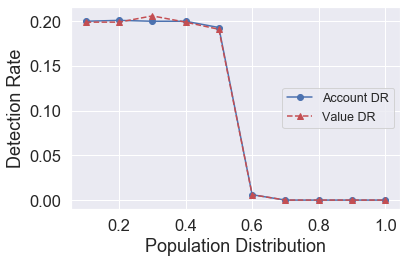

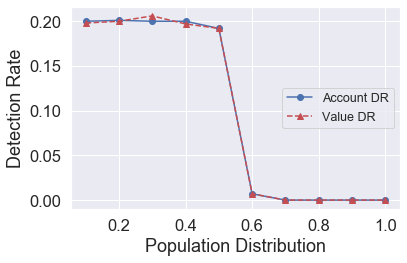

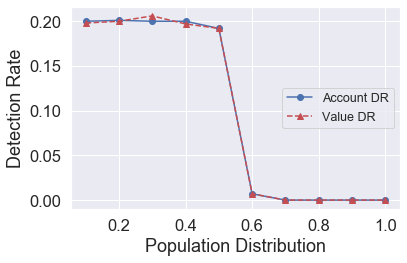

In [102]:
ev.plot_ADR_Quantile(lt_lgbm_iterative)
ev.plot_ADR_Quantile(lt_lgbm_fixed)
ev.plot_ADR_Quantile(lt_lgbm_random)

### Plot lightGBM Cum. Detection rate vs. Population Distribution (Gains chart)

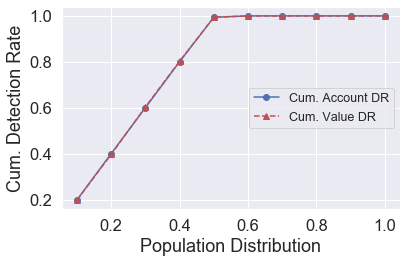

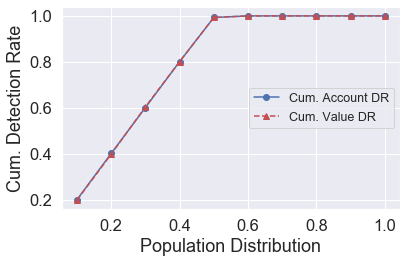

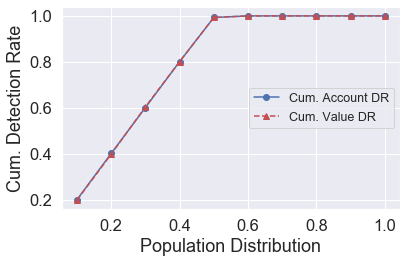

In [103]:
ev.plot_cADR_Quantile(lt_lgbm_iterative)
ev.plot_cADR_Quantile(lt_lgbm_fixed)
ev.plot_cADR_Quantile(lt_lgbm_random)

In [104]:
#skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)


### Plot lightGBM FPR vs. Population Distribution

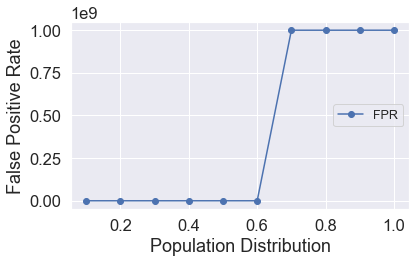

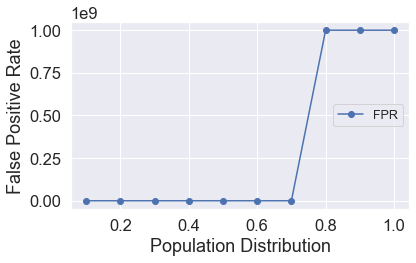

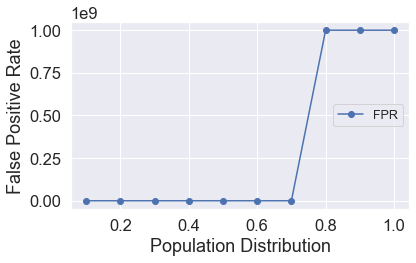

In [105]:
ev.plot_FPR_Quantile(lt_lgbm_iterative)
ev.plot_FPR_Quantile(lt_lgbm_fixed)
ev.plot_FPR_Quantile(lt_lgbm_random)

### Plot lightGBM Cum. FPR vs. Population Distribution

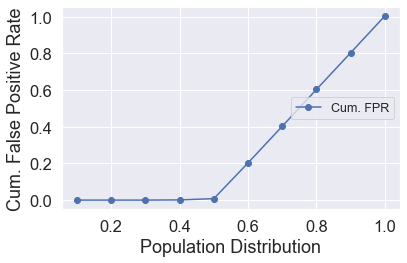

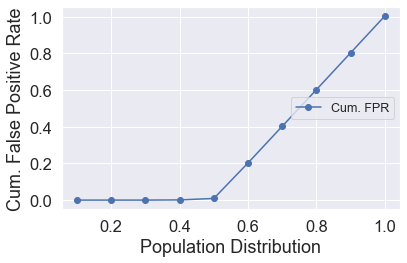

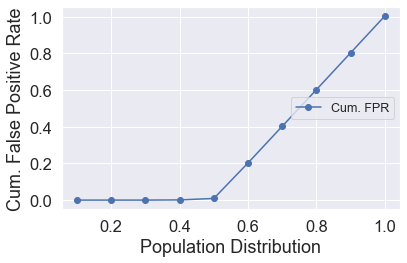

In [106]:
ev.plot_cFPR_Quantile(lt_lgbm_iterative)
ev.plot_cFPR_Quantile(lt_lgbm_fixed)
ev.plot_cFPR_Quantile(lt_lgbm_random)

### Plot lightGBM ROC curve

Random: ROC AUC=0.500
Model: ROC AUC=0.999


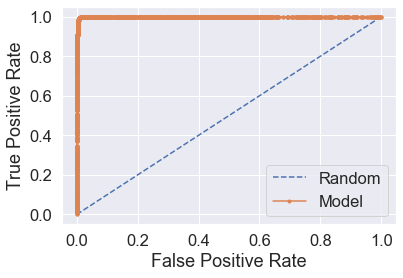

Random: ROC AUC=0.500
Model: ROC AUC=0.999


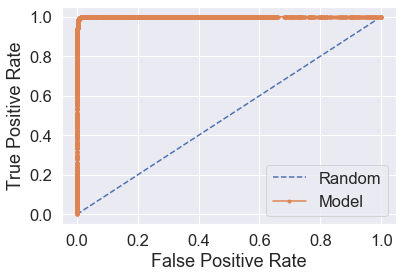

Random: ROC AUC=0.500
Model: ROC AUC=0.999


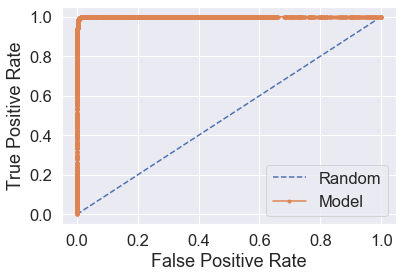

In [107]:
ev.plot_ROC_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='lightgbm_score_iterative', weight_variable=weight_variable_name) 
ev.plot_ROC_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='lightgbm_score_fixed', weight_variable=weight_variable_name) 
ev.plot_ROC_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='lightgbm_score_random', weight_variable=weight_variable_name) 

### Plot lightGBM Precision Recall curve

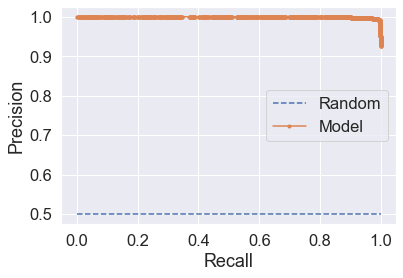

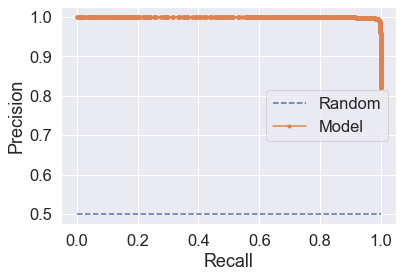

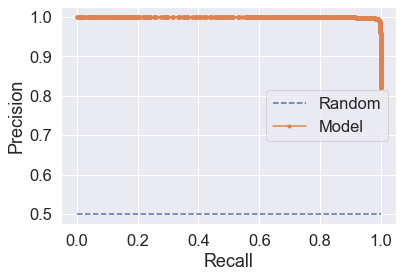

In [108]:
ev.plot_precision_recall_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='lightgbm_score_iterative', 
                            weight_variable=weight_variable_name)
ev.plot_precision_recall_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='lightgbm_score_fixed', 
                            weight_variable=weight_variable_name)
ev.plot_precision_recall_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='lightgbm_score_random', 
                            weight_variable=weight_variable_name)  

### Plot lightGBM F1 score, Accuracy, Sensitivity, Specificity, Precision vs Cutoff

..\functions\evaluation.py:561: RuntimeWarning: invalid value encountered in double_scalars
  model_precision = true_positive/(true_positive+false_positive)


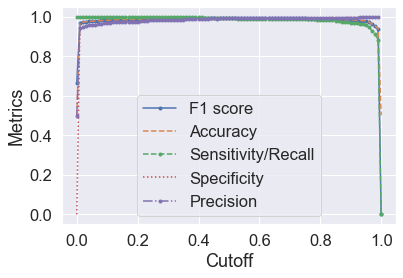

..\functions\evaluation.py:561: RuntimeWarning: invalid value encountered in double_scalars
  model_precision = true_positive/(true_positive+false_positive)


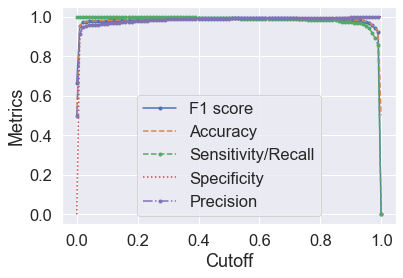

..\functions\evaluation.py:561: RuntimeWarning: invalid value encountered in double_scalars
  model_precision = true_positive/(true_positive+false_positive)


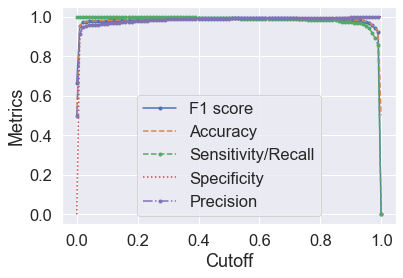

In [109]:
ev.plot_cutoffs(table_name=oos, target_variable=target_variable_name, predicted_variable='lightgbm_score_iterative', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)
ev.plot_cutoffs(table_name=oos, target_variable=target_variable_name, predicted_variable='lightgbm_score_fixed', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)
ev.plot_cutoffs(table_name=oos, target_variable=target_variable_name, predicted_variable='lightgbm_score_random', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)

# Keras NN

## Feature selection Keras Neural Network

### First find neural network hyperparameters for a decent network using RandomizedSearchCV, then select the top variables based on that network

In [110]:
import math
from keras.wrappers.scikit_learn import KerasClassifier

grid = [
# SGD optimizer
    {
    'num_neurons': [math.floor((len(keep_gini_vars)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [dev[keep_gini_vars].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['SGD']
    , 'learning_rate': [0.01, 0.001, 0.10, 0.30]
    , 'momentum': [0.0, 0.25, 0.5]
    , 'rho': [99999]
    , 'beta_1': [99999]
    , 'beta_2': [99999]
    , 'return_metrics': ['False']
    , 'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
},
# Adadelta optimizer
    {
    'num_neurons': [math.floor((len(keep_gini_vars)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [dev[keep_gini_vars].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Adadelta']
    , 'learning_rate': [1, 0.5, 0.7, 0.9]
    , 'momentum': [0.0, 0.25, 0.5]
    , 'rho': [0.95, 0.8, 0.9, 0.99]
    , 'beta_1': [99999]
    , 'beta_2': [99999]
    , 'return_metrics': ['False']
    , 'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
}, 
# Adam optimizer
    {
    'num_neurons': [math.floor((len(keep_gini_vars)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [dev[keep_gini_vars].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Adam']
    , 'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]
    , 'momentum': [99999]
    , 'rho': [99999]
    , 'beta_1': [0.9, 0.8, 0.95, 0.99]
    , 'beta_2': [0.999, 0.8, 0.9, 0.95]
    , 'return_metrics': ['False']
    , 'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
}, 
# Nadam optimizer
    {
    'num_neurons': [math.floor((len(keep_gini_vars)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [dev[keep_gini_vars].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Nadam']
    , 'learning_rate': [0.002, 0.01, 0.1, 0.2]
    , 'momentum': [99999]
    , 'rho': [99999]
    , 'beta_1': [0.9, 0.8, 0.95, 0.99]
    , 'beta_2': [0.999, 0.8, 0.9, 0.95]
    , 'return_metrics': ['False']
    , 'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
}, 
# Adamax optimizer
    {
    'num_neurons': [math.floor((len(keep_gini_vars)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [dev[keep_gini_vars].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Adamax']
    , 'learning_rate': [0.002, 0.01, 0.1, 0.2]
    , 'momentum': [99999]
    , 'rho': [99999]
    , 'beta_1': [0.9, 0.8, 0.95, 0.99]
    , 'beta_2': [0.999, 0.8, 0.9, 0.95]
    , 'return_metrics': ['False']
    , 'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
}
]

params=[{'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': dev[keep_gini_vars].shape[1], 
             'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 
             'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 
             'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 
             'return_metrics': 'False', 'batch_size': None, 'epochs': 1}
        , {'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': dev[keep_gini_vars].shape[1], 
             'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 
             'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 
             'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 
             'return_metrics': 'False', 'batch_size': None, 'epochs': 1}
        , {'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': dev[keep_gini_vars].shape[1], 
             'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 
             'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 
             'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 
             'return_metrics': 'False', 'batch_size': None, 'epochs': 1}
        , {'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': dev[keep_gini_vars].shape[1], 
                     'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 
                     'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 
                     'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 
                     'return_metrics': 'False', 'batch_size': None, 'epochs': 1}
        , {'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': dev[keep_gini_vars].shape[1], 
                     'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 
                     'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 
                     'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 
                     'return_metrics': 'False', 'batch_size': None, 'epochs': 1}]

In [111]:
import timeit
start = timeit.default_timer()

opt_params_dict, loss_dict = mb.step_search_weight(estimator=KerasClassifier, params=params, grid=grid, target=target_variable_name,
    weight=weight_variable_name, dev=dev, val=oos, keep=keep_gini_vars)

print('\n Best Parameters for each optimizer')
print(opt_params_dict)
print(loss_dict)

loss = loss_dict[loss_dict.index(min(loss_dict))]
opt_params = opt_params_dict[loss_dict.index(min(loss_dict))]
print('\n Best Parameters')
print(opt_params)
print(loss)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  2544.1952324999997

Search Progress:
{'num_neurons': 26, 'num_hidden_layers': 2, 'input_dim': 52, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} num_neurons 26 0.692504834033699 0.692504834033699

{'num_neurons': 26, 'num_hidden_layers': 1, 'input_dim': 52, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} num_hidden_layers 1 0.6607999178727095 0.6607999178727095
{'num_neurons': 26,

{'num_neurons': 26, 'num_hidden_layers': 1, 'input_dim': 52, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 4, 'dropout_rate': 0.5, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0.75 0.41080791942553563 0.38025706056897746

{'num_neurons': 26, 'num_hidden_layers': 1, 'input_dim': 52, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 4, 'dropout_rate': 0.5, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} output_kernel_initializer uniform 0.4365401031633872 0.38025706056897746

{'num

{'num_neurons': 26, 'num_hidden_layers': 2, 'input_dim': 52, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation elu 0.03195808685074063 0.027313390502882742
{'num_neurons': 26, 'num_hidden_layers': 2, 'input_dim': 52, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation linear 0.03226234691396471 0.027313390502882742
{'num_neurons': 26, 'num_

{'num_neurons': 26, 'num_hidden_layers': 2, 'input_dim': 52, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0.75 0.046806471331064935 0.027313390502882742

{'num_neurons': 26, 'num_hidden_layers': 2, 'input_dim': 52, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} output_kernel_initializer uniform 0.029232663435518013 0.027313390502882742

{'

{'num_neurons': 26, 'num_hidden_layers': 2, 'input_dim': 52, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_initializer normal 0.05959428497732768 0.05071502611935811
{'num_neurons': 26, 'num_hidden_layers': 2, 'input_dim': 52, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_initializer uniform 0.05390911869788274 0.05071502611935811

{'nu

{'num_neurons': 26, 'num_hidden_layers': 2, 'input_dim': 52, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0.75 0.07699252245007235 0.0486042049300554

{'num_neurons': 26, 'num_hidden_layers': 2, 'input_dim': 52, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} output_kernel_initializer uniform 0.04873655750230831 0.0486042049300554

{'

{'num_neurons': 26, 'num_hidden_layers': 2, 'input_dim': 52, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} num_hidden_layers 2 0.029781369257721544 0.029781369257721544

{'num_neurons': 26, 'num_hidden_layers': 2, 'input_dim': 52, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} input_dim 52 0.03039278962008395 0.029781369257721544

{'num_neurons': 26

{'num_neurons': 26, 'num_hidden_layers': 2, 'input_dim': 52, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 0.999 0.028056859726632168 0.02754713286840313
{'num_neurons': 26, 'num_hidden_layers': 2, 'input_dim': 52, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 0.8 0.03802032212156905 0.02754713286840313
{'num_neurons': 26, 'num_hidden_l

{'num_neurons': 26, 'num_hidden_layers': 2, 'input_dim': 52, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0.5 0.09257046263439239 0.05762937748145226
{'num_neurons': 26, 'num_hidden_layers': 2, 'input_dim': 52, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 4, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} dropout_rate 0.75 0.17092777214712 0.05762937748145226

{'num_neurons': 2

[{'num_neurons': 26, 'num_hidden_layers': 1, 'input_dim': 52, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 4, 'dropout_rate': 0.5, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.3, 'momentum': 0.0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': 32, 'epochs': 1}, {'num_neurons': 26, 'num_hidden_layers': 2, 'input_dim': 52, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 10}, {'num_neurons': 26, 'num_hidden_layers': 2, 'input_dim': 52, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint'

In [112]:
# Select the top features
feats_best_keras = ks_fn.top_keras_feat(dev_df=dev, feats=keep_gini_vars, target=target_variable_name, weight_variable=weight_variable_name, 
                                  threshold=0.0001, keras_function=ks_fn.neural_network_function_wrapper(
    num_neurons_=[x[1] for x in list(opt_params.items()) if x[0]=='num_neurons'][0]
    , num_hidden_layers_=[x[1] for x in list(opt_params.items()) if x[0]=='num_hidden_layers'][0]
    , input_dim_=[x[1] for x in list(opt_params.items()) if x[0]=='input_dim'][0]
    , kernel_initializer_=[x[1] for x in list(opt_params.items()) if x[0]=='kernel_initializer'][0]
    , activation_=[x[1] for x in list(opt_params.items()) if x[0]=='activation'][0]
    , kernel_constraint_=[x[1] for x in list(opt_params.items()) if x[0]=='kernel_constraint'][0]
    , dropout_rate_=[x[1] for x in list(opt_params.items()) if x[0]=='dropout_rate'][0]
    , output_kernel_initializer_=[x[1] for x in list(opt_params.items()) if x[0]=='output_kernel_initializer'][0]
    , output_activation_=[x[1] for x in list(opt_params.items()) if x[0]=='output_activation'][0]
    , loss_=[x[1] for x in list(opt_params.items()) if x[0]=='loss'][0]
    , optimizer_=[x[1] for x in list(opt_params.items()) if x[0]=='optimizer'][0]
    , learning_rate_=[x[1] for x in list(opt_params.items()) if x[0]=='learning_rate'][0]
    , momentum_=[x[1] for x in list(opt_params.items()) if x[0]=='momentum'][0]
    , rho_=[x[1] for x in list(opt_params.items()) if x[0]=='rho'][0]
    , beta_1_=[x[1] for x in list(opt_params.items()) if x[0]=='beta_1'][0]
    , beta_2_=[x[1] for x in list(opt_params.items()) if x[0]=='beta_2'][0]
    , return_metrics_='True'), 
                epochs_=[x[1] for x in list(opt_params.items()) if x[0]=='epochs'][0]
              , batch_size_=[x[1] for x in list(opt_params.items()) if x[0]=='batch_size'][0]
            , feat_importance_num_display = 1000
                                 )

feats_best_keras

Weight,Feature
0.4329 ± 0.0079,numeric7
0.0135 ± 0.0031,numeric6
0.0091 ± 0.0026,numeric8
0.0007 ± 0.0006,numeric2
0.0004 ± 0.0007,numeric1
0.0003 ± 0.0003,numeric4
0.0001 ± 0.0000,character2_nan
0 ± 0.0000,character6_17
0 ± 0.0000,character2_9.0
0 ± 0.0000,character1_4


['numeric7',
 'numeric6',
 'numeric8',
 'numeric4',
 'numeric2',
 'numeric1',
 'character2_nan']

### Grid search based on iterative step search

In [113]:
import math
from keras.wrappers.scikit_learn import KerasClassifier

grid = [
# SGD optimizer
    {
    'num_neurons': [math.floor((len(feats_best_keras)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [dev[feats_best_keras].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['SGD']
    , 'learning_rate': [0.01, 0.001, 0.10, 0.30]
    , 'momentum': [0.0, 0.25, 0.5]
    , 'rho': [99999]
    , 'beta_1': [99999]
    , 'beta_2': [99999]
    , 'return_metrics': ['False']
    , 'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
},
# Adadelta optimizer
    {
    'num_neurons': [math.floor((len(feats_best_keras)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [dev[feats_best_keras].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Adadelta']
    , 'learning_rate': [1, 0.5, 0.7, 0.9]
    , 'momentum': [0.0, 0.25, 0.5]
    , 'rho': [0.95, 0.8, 0.9, 0.99]
    , 'beta_1': [99999]
    , 'beta_2': [99999]
    , 'return_metrics': ['False']
    , 'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
}, 
# Adam optimizer
    {
    'num_neurons': [math.floor((len(feats_best_keras)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [dev[feats_best_keras].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Adam']
    , 'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]
    , 'momentum': [99999]
    , 'rho': [99999]
    , 'beta_1': [0.9, 0.8, 0.95, 0.99]
    , 'beta_2': [0.999, 0.8, 0.9, 0.95]
    , 'return_metrics': ['False']
    , 'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
}, 
# Nadam optimizer
    {
    'num_neurons': [math.floor((len(feats_best_keras)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [dev[feats_best_keras].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Nadam']
    , 'learning_rate': [0.002, 0.01, 0.1, 0.2]
    , 'momentum': [99999]
    , 'rho': [99999]
    , 'beta_1': [0.9, 0.8, 0.95, 0.99]
    , 'beta_2': [0.999, 0.8, 0.9, 0.95]
    , 'return_metrics': ['False']
    , 'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
}, 
# Adamax optimizer
    {
    'num_neurons': [math.floor((len(feats_best_keras)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [dev[feats_best_keras].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Adamax']
    , 'learning_rate': [0.002, 0.01, 0.1, 0.2]
    , 'momentum': [99999]
    , 'rho': [99999]
    , 'beta_1': [0.9, 0.8, 0.95, 0.99]
    , 'beta_2': [0.999, 0.8, 0.9, 0.95]
    , 'return_metrics': ['False']
    , 'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
}
]

params=[{'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': dev[feats_best_keras].shape[1], 
             'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 
             'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 
             'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 
             'return_metrics': 'False', 'batch_size': None, 'epochs': 1}
        , {'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': dev[feats_best_keras].shape[1], 
             'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 
             'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 
             'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 
             'return_metrics': 'False', 'batch_size': None, 'epochs': 1}
        , {'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': dev[feats_best_keras].shape[1], 
             'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 
             'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 
             'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 
             'return_metrics': 'False', 'batch_size': None, 'epochs': 1}
        , {'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': dev[feats_best_keras].shape[1], 
                     'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 
                     'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 
                     'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 
                     'return_metrics': 'False', 'batch_size': None, 'epochs': 1}
        , {'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': dev[feats_best_keras].shape[1], 
                     'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 
                     'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 
                     'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 
                     'return_metrics': 'False', 'batch_size': None, 'epochs': 1}]

In [114]:
import timeit
start = timeit.default_timer()

opt_params_dict, loss_dict = mb.step_search_weight(estimator=KerasClassifier, params=params, grid=grid, target=target_variable_name,
    weight=weight_variable_name, dev=dev, val=oos, keep=feats_best_keras)

print('\n Best Parameters for each optimizer')
print(opt_params_dict)
print(loss_dict)

loss = loss_dict[loss_dict.index(min(loss_dict))]
opt_params_iterative = opt_params_dict[loss_dict.index(min(loss_dict))]
print('\n Best Parameters')
print(opt_params_iterative)
print(loss)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  2120.6510301999997



Search Progress:
{'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': 7, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} num_neurons 4 0.6931144013069405 0.6931144013069405

{'num_neurons': 4, 'num_hidden_layers': 1, 'input_dim': 7, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} num_hidden_layers 1 0.683245769135929 0.683245769135929
{'num_neurons': 4, 'num_

{'num_neurons': 4, 'num_hidden_layers': 1, 'input_dim': 7, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.3, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_1 99999 0.03249155067430655 0.03249155067430655

{'num_neurons': 4, 'num_hidden_layers': 1, 'input_dim': 7, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'learning_rate': 0.3, 'momentum': 0.5, 'rho': 99999, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 99999 0.0329973929814129 0.03249155067430655

{'num_neurons': 4, 'num_hidden_layers

{'num_neurons': 4, 'num_hidden_layers': 1, 'input_dim': 7, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} output_kernel_initializer uniform 0.05495957806994613 0.048048487390716904

{'num_neurons': 4, 'num_hidden_layers': 1, 'input_dim': 7, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adadelta', 'learning_rate': 1, 'momentum': 0.0, 'rho': 0.95, 'beta_1': 99999, 'beta_2': 99999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} output_activation sigmoid 0.05657198156340286 0.048048487390716904



{'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': 7, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_initializer uniform 0.5922728442205021 0.49422896609413064

{'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': 7, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} activation relu 0.4983371071965129 0.49422896609413064
{'num_neurons': 4, '

{'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': 7, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 0.9 0.03892643932283832 0.032866809821444
{'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': 7, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'learning_rate': 0.01, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 0.95 0.0375638804674992 0.032866809821444

{'num_neurons': 4, 'num_hidden_layers':

{'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': 7, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 3, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} output_kernel_initializer uniform 0.11232613734352932 0.11034304320660691

{'num_neurons': 4, 'num_hidden_layers': 2, 'input_dim': 7, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 3, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Nadam', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} output_activation sigmoid 0.11676506804857975 0.1103430432066

{'num_neurons': 4, 'num_hidden_layers': 1, 'input_dim': 7, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_initializer normal 0.5439351954148377 0.5318067891355225
{'num_neurons': 4, 'num_hidden_layers': 1, 'input_dim': 7, 'kernel_initializer': 'normal', 'activation': 'relu', 'kernel_constraint': 2, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.002, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.9, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} kernel_initializer uniform 0.5543918072876446 0.5318067891355225

{'num_ne

{'num_neurons': 4, 'num_hidden_layers': 1, 'input_dim': 7, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.1, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 0.9 0.05279151550232513 0.03262788181102295
{'num_neurons': 4, 'num_hidden_layers': 1, 'input_dim': 7, 'kernel_initializer': 'normal', 'activation': 'linear', 'kernel_constraint': 5, 'dropout_rate': 0, 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'learning_rate': 0.1, 'momentum': 99999, 'rho': 99999, 'beta_1': 0.95, 'beta_2': 0.999, 'return_metrics': 'False', 'batch_size': None, 'epochs': 1} beta_2 0.95 0.05246049565872143 0.03262788181102295

{'num_neurons': 4, 'num_hidden_l

In [115]:
# Load NN machine leanring library
from keras.wrappers.scikit_learn import KerasClassifier

# Define the Keras model
nn = KerasClassifier(build_fn=ks_fn.neural_network_function_wrapper(
    num_neurons_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='num_neurons'][0]
    , num_hidden_layers_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='num_hidden_layers'][0]
    , input_dim_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='input_dim'][0]
    , kernel_initializer_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='kernel_initializer'][0]
    , activation_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='activation'][0]
    , kernel_constraint_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='kernel_constraint'][0]
    , dropout_rate_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='dropout_rate'][0]
    , output_kernel_initializer_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='output_kernel_initializer'][0]
    , output_activation_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='output_activation'][0]
    , loss_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='loss'][0]
    , optimizer_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='optimizer'][0]
    , learning_rate_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='learning_rate'][0]
    , momentum_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='momentum'][0]
    , rho_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='rho'][0]
    , beta_1_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='beta_1'][0]
    , beta_2_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='beta_2'][0]
    , return_metrics_='True'), verbose=0)

nn_model = nn.fit(dev[feats_best_keras].values, dev[target_variable_name], sample_weight=dev[weight_variable_name].values, use_multiprocessing=True, 
          workers=8, verbose=0, epochs=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='epochs'][0]
              , batch_size=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='batch_size'][0])

# Compute the score for the OOT data
oos['nn_score_iterative'] = nn.predict_proba(oos[feats_best_keras].values)[:, 1]

### Grid search based on RandomizedSearchCV - also uses cross-validation

Execution time in seconds:  936.7140196
The best hyperparameter set is: {'rho': 99999, 'return_metrics': 'False', 'output_kernel_initializer': 'uniform', 'output_activation': 'sigmoid', 'optimizer': 'Adamax', 'num_neurons': 4, 'num_hidden_layers': 2, 'momentum': 99999, 'loss': 'binary_crossentropy', 'learning_rate': 0.002, 'kernel_initializer': 'normal', 'kernel_constraint': 4, 'input_dim': 7, 'epochs': 1000, 'dropout_rate': 0, 'beta_2': 0.999, 'beta_1': 0.99, 'batch_size': 64, 'activation': 'elu'}
Mean loss function for cross-validation test data:  0.026383018479408264
Standard deviation loss function for cross-validation test data:  0.002082580115149904


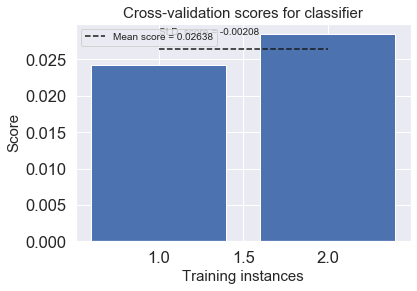

In [116]:
import math

import timeit
start = timeit.default_timer()

# define the grid search parameters
grid = [
# SGD optimizer
    {
    'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
    , 'num_neurons': [math.floor((len(feats_best_keras)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [dev[feats_best_keras].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['SGD']
    , 'learning_rate': [0.01, 0.001, 0.10, 0.30]
    , 'momentum': [0.0, 0.25, 0.5]
    , 'rho': [99999]
    , 'beta_1': [99999]
    , 'beta_2': [99999]
    , 'return_metrics': ['False']
},
# Adadelta optimizer
    {
    'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
    , 'num_neurons': [math.floor((len(feats_best_keras)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [dev[feats_best_keras].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Adadelta']
    , 'learning_rate': [1, 0.5, 0.7, 0.9]
    , 'momentum': [0.0, 0.25, 0.5]
    , 'rho': [0.95, 0.8, 0.9, 0.99]
    , 'beta_1': [99999]
    , 'beta_2': [99999]
    , 'return_metrics': ['False']
}, 
# Adam optimizer
    {
    'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
    , 'num_neurons': [math.floor((len(feats_best_keras)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [dev[feats_best_keras].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Adam']
    , 'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]
    , 'momentum': [99999]
    , 'rho': [99999]
    , 'beta_1': [0.9, 0.8, 0.95, 0.99]
    , 'beta_2': [0.999, 0.8, 0.9, 0.95]
    , 'return_metrics': ['False']
}, 
# Nadam optimizer
    {
    'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
    , 'num_neurons': [math.floor((len(feats_best_keras)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [dev[feats_best_keras].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Nadam']
    , 'learning_rate': [0.002, 0.01, 0.1, 0.2]
    , 'momentum': [99999]
    , 'rho': [99999]
    , 'beta_1': [0.9, 0.8, 0.95, 0.99]
    , 'beta_2': [0.999, 0.8, 0.9, 0.95]
    , 'return_metrics': ['False']
}, 
# Adamax optimizer
    {
    'batch_size': [None, 32, 64, 128]
    , 'epochs': [1, 10, 100, 500, 1000]
    , 'num_neurons': [math.floor((len(feats_best_keras)+1)/2)]
    , 'num_hidden_layers': [1, 2]
    , 'input_dim': [dev[feats_best_keras].shape[1]]
    , 'kernel_initializer': ['normal', 'uniform']
    , 'activation': ['relu', 'elu', 'linear', 'softplus']
    , 'kernel_constraint': [0,1,2,3,4,5]
    , 'dropout_rate': [0, 0.25, 0.5, 0.75]
    , 'output_kernel_initializer': ['uniform']
    , 'output_activation': ['sigmoid']
    , 'loss': ['binary_crossentropy']
    , 'optimizer': ['Adamax']
    , 'learning_rate': [0.002, 0.01, 0.1, 0.2]
    , 'momentum': [99999]
    , 'rho': [99999]
    , 'beta_1': [0.9, 0.8, 0.95, 0.99]
    , 'beta_2': [0.999, 0.8, 0.9, 0.95]
    , 'return_metrics': ['False']
}
]

kerasnn_grid_random_search = mb.grid_search_cv(
    n_splits = 2, # Number of cross-validation splits
    classifier = KerasClassifier, # Classifier name, e.g. RandomForestClassifier
    keras_function = ks_fn.neural_network_function_wrapper(
    num_neurons_=20
    , num_hidden_layers_=1
    , input_dim_=dev[keep_gini_vars].shape[1]
    , kernel_initializer_='normal'
    , activation_='relu'
    , kernel_constraint_=0
    , dropout_rate_=0.5
    , output_kernel_initializer_='normal'
    , output_activation_='sigmoid'
    , loss_='binary_crossentropy'
    , optimizer_='Adam'
    , learning_rate_=0.01
    , momentum_=0.0
    , rho_=0.95
    , beta_1_=0.9
    , beta_2_=0.999
    , return_metrics_='False'
),
    grid_params = grid, # Grid space
    dev_df = dev,  # Development sample that this will analysis will be performed
    feats = feats_best_keras, # List of predictor names
    target = target_variable_name, # Target variable name
    weight_variable = weight_variable_name, # Weight variable name
    randomized_search = True, # Set to True if randomized grid search will be performed, or to False if exhaustive grid search will be performed
    n_random_grids = 50, # Number of grid searches when randomized_search=True. If randomized_search=False, then this parameter is not applicable
    random_state = None, # If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.
    n_jobs = 8 # Number of jobs to run in parallel
)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  850.7581530999996

opt_params_fixed = kerasnn_grid_random_search.best_params_
print('The best hyperparameter set is:', opt_params_fixed)
print('Mean loss function for cross-validation test data: ', -kerasnn_grid_random_search.cv_results_['mean_test_score'][kerasnn_grid_random_search.best_index_])
print('Standard deviation loss function for cross-validation test data: ', kerasnn_grid_random_search.cv_results_['std_test_score'][kerasnn_grid_random_search.best_index_])

ev.plot_cross_validation_score(model=kerasnn_grid_random_search)

# Compute the score for the OOT data
oos['nn_score_random'] = kerasnn_grid_random_search.predict_proba(oos[feats_best_keras].values)[:, 1]

### Grid search based on AutoKeras

In [117]:
# DRAWBACKS
# 1) Autokeras does not optimize batch_size and epochs
# 2) Autokeras cannot incorporate weights

import timeit
start = timeit.default_timer()

import autokeras as ak

# Set the number of iterations
num_trials = 2

# Initialize the structured data classifier.
clf = ak.StructuredDataClassifier(column_names=feats_best_keras, loss='binary_crossentropy'
                                  , max_trials=num_trials
                                 , directory=r'C:\Data_Science'                                  
) 

###############################################################################################################
# Data standardization with sklearn
from sklearn.preprocessing import StandardScaler
# create scaler
scaler = StandardScaler()
###############################################################################################################
# Data normalization with sklearn
#from sklearn.preprocessing import MinMaxScaler
# create scaler
#scaler = MinMaxScaler()
###############################################################################################################
# fit scaler on data
scaler.fit(dev[feats_best_keras].values.astype('float32'))
# apply transform
x_train = scaler.transform(dev[feats_best_keras].values.astype('float32'))
x_test = scaler.transform(oos[feats_best_keras].values.astype('float32'))

y_train = dev[target_variable_name]
y_test = oos[target_variable_name]

# Feed the structured data classifier with training data.
clf.fit(x=x_train, y=y_train
#        , sample_weight=dev[weight_variable_name].values
       , use_multiprocessing=True, workers=8, verbose=0
        , validation_data=(oos[feats_best_keras].values, oos[target_variable_name])
#              , epochs=[x[1] for x in list(opt_params_fixed.items()) if x[0]=='epochs'][0]
#              , batch_size=[x[1] for x in list(opt_params_fixed.items()) if x[0]=='batch_size'][0]       
       )

# Evaluate the best model with testing data.
autokeras_loss, autokeras_accuracy = clf.evaluate(x=oos[feats_best_keras].values, y=oos[target_variable_name], verbose=0)
print('Loss: %.3f' % autokeras_loss)
print('Accuracy: %.3f' % autokeras_accuracy)

# Evaluate the Auto-Keras model
from sklearn.metrics import classification_report
predictions = clf.predict(x=oos[feats_best_keras])
report = classification_report(oos[target_variable_name], predictions)
print(report)

stop = timeit.default_timer()
print('Execution time in seconds: ', stop - start)  
#Execution time in seconds:  202.19050749999587

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Loss: 0.418
Accuracy: 0.814


              precision    recall  f1-score   support

           0       0.92      0.69      0.79      1503
           1       0.75      0.94      0.83      1497

    accuracy                           0.81      3000
   macro avg       0.84      0.81      0.81      3000
weighted avg       0.84      0.81      0.81      3000

Execution time in seconds:  38.45488840000053


In [118]:
# Get the best performing model
#best_model = clf.export_model()
#best_model.summary()

## Calculate NN feature importance

In [119]:
ks_fn.top_keras_feat(dev_df=dev, feats=feats_best_keras, target=target_variable_name, weight_variable=weight_variable_name, 
                                  threshold=0, keras_function=ks_fn.neural_network_function_wrapper(
    num_neurons_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='num_neurons'][0]
    , num_hidden_layers_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='num_hidden_layers'][0]
    , input_dim_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='input_dim'][0]
    , kernel_initializer_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='kernel_initializer'][0]
    , activation_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='activation'][0]
    , kernel_constraint_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='kernel_constraint'][0]
    , dropout_rate_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='dropout_rate'][0]
    , output_kernel_initializer_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='output_kernel_initializer'][0]
    , output_activation_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='output_activation'][0]
    , loss_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='loss'][0]
    , optimizer_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='optimizer'][0]
    , learning_rate_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='learning_rate'][0]
    , momentum_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='momentum'][0]
    , rho_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='rho'][0]
    , beta_1_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='beta_1'][0]
    , beta_2_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='beta_2'][0]
    , return_metrics_='True'), 
                epochs_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='epochs'][0]
              , batch_size_=[x[1] for x in list(opt_params_iterative.items()) if x[0]=='batch_size'][0]
            , feat_importance_num_display = 1000
                                 )

Weight,Feature
0.4069 ± 0.0063,numeric7
0.0295 ± 0.0024,numeric6
0.0098 ± 0.0020,numeric8
0.0010 ± 0.0006,numeric2
0.0006 ± 0.0004,numeric1
0.0003 ± 0.0004,numeric4
-0.0000 ± 0.0001,character2_nan


['numeric7', 'numeric6', 'numeric8', 'numeric4', 'numeric2', 'numeric1']

## Calculate NN log-loss

In [120]:
from sklearn.metrics import log_loss
print ("log-loss_iterative")
print(log_loss(y_true=oos[target_variable_name].values, y_pred=oos['nn_score_iterative'].values, sample_weight=oos[weight_variable_name].values, eps=1e-15))
print ("log-loss_random")
print(log_loss(y_true=oos[target_variable_name].values, y_pred=oos['nn_score_random'].values, sample_weight=oos[weight_variable_name].values, eps=1e-15))

log-loss_iterative


C:\Data_Science\Anaconda3\envs\envpip\lib\site-packages\sklearn\metrics\_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Data_Science\Anaconda3\envs\envpip\lib\site-packages\sklearn\metrics\_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


nan
log-loss_random
0.025564200435951676


## Calculate NN Precision/Recall Area Under the Curve

In [121]:
print ("precision_recall_auc_iterative")
print(ev.auc_precision_recall(table_name=oos, target_variable=target_variable_name, predicted_variable='nn_score_iterative', 
                            weight_variable=weight_variable_name))
print ("precision_recall_auc_random")
print(ev.auc_precision_recall(table_name=oos, target_variable=target_variable_name, predicted_variable='nn_score_random', 
                            weight_variable=weight_variable_name))

precision_recall_auc_iterative
0.9993658745544978
precision_recall_auc_random
0.9994508320637787


## Calculate NN Gini, for the top population

In [122]:
print ("unit_gini_iterative")
print(ev.calculate_gini(
    table_name=oos, # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='nn_score_iterative', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))
print ("unit_gini_random")
print(ev.calculate_gini(
    table_name=oos, # Table name
    target_variable=target_variable_name, # Target variable name
    predicted_variable='nn_score_random', # Predicted variable name
    weight_variable=weight_variable_name, # Weight variable name
    select_top_percent=100 # Percent between 0 and 100: Gini is calculated for the top select_top_percent% of the observations, sorted by score
    ))

unit_gini_iterative
0.9988026463440565
unit_gini_random
0.9989383856739549


## Calculate NN Lifting table

In [123]:
# Lifting table
lt_nn_iterative = ev.lift_table_weight(oos[['nn_score_iterative', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_nn_random = ev.lift_table_weight(oos[['nn_score_random', target_variable_name, amount_variable_name, weight_variable_name]].values, n_bands=10, rows=10).round(decimals=3)
lt_nn_iterative

,Quantile Unit,# Cases,# Responses,Cumulative # Responses,% Response,FPR,Cumulative FPR,ADR,Cumulative ADR,Lift,Cumulative Lift,Quantile Value,Value,Cumulative Value,VDR,Cumulative VDR
0,0.100,455.857,455.857,455.857,1.000,0.000000e+00,0.000,0.200,0.200,2.005,2.005,0.100,4554321.772,4.554322e+06,0.202,0.202
1,0.199,454.043,454.043,909.900,1.000,0.000000e+00,0.000,0.199,0.400,2.005,2.005,0.199,4381913.462,8.936235e+06,0.194,0.396
2,0.300,458.899,458.899,1368.799,1.000,0.000000e+00,0.000,0.202,0.601,2.005,2.005,0.300,4618848.642,1.355508e+07,0.205,0.600
3,0.400,456.791,455.785,1824.584,0.998,2.000000e-03,0.001,0.200,0.801,2.000,2.004,0.400,4606975.685,1.816206e+07,0.204,0.804
4,0.500,456.001,437.837,2262.421,0.960,4.100000e-02,0.008,0.192,0.994,1.925,1.988,0.500,4271850.513,2.243391e+07,0.189,0.993
5,0.600,457.398,14.744,2277.165,0.032,3.002200e+01,0.203,0.006,1.000,0.065,1.667,0.600,151357.562,2.258527e+07,0.007,1.000
6,0.700,456.037,0.000,2277.165,0.000,1.000000e+09,0.403,0.000,1.000,0.000,1.429,0.700,0.000,2.258527e+07,0.000,1.000
7,0.800,456.078,0.000,2277.165,0.000,1.000000e+09,0.603,0.000,1.000,0.000,1.250,0.800,0.000,2.258527e+07,0.000,1.000
8,0.900,456.820,0.000,2277.165,0.000,1.000000e+09,0.804,0.000,1.000,0.000,1.111,0.900,0.000,2.258527e+07,0.000,1.000
9,1.000,457.141,0.000,2277.165,0.000,1.000000e+09,1.005,0.000,1.000,0.000,1.000,1.000,0.000,2.258527e+07,0.000,1.000


## Plots NN

### Plot NN Detection rate vs. Population Distribution

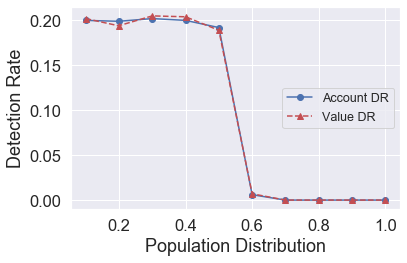

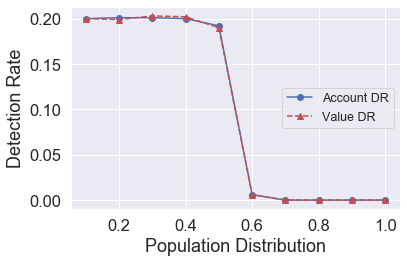

In [124]:
ev.plot_ADR_Quantile(lt_nn_iterative)
ev.plot_ADR_Quantile(lt_nn_random)

### Plot NN Cum. Detection rate vs. Population Distribution (Gains chart)

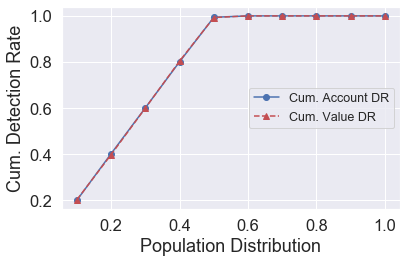

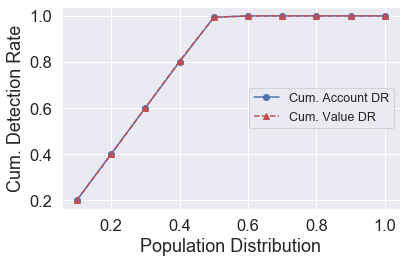

In [125]:
ev.plot_cADR_Quantile(lt_nn_iterative)
ev.plot_cADR_Quantile(lt_nn_random)

### Plot NN FPR vs. Population Distribution

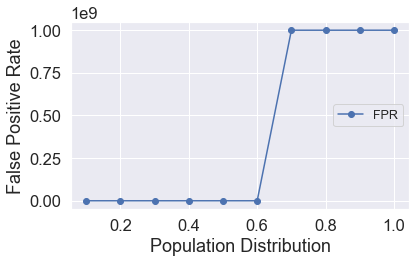

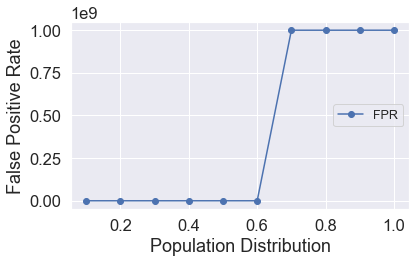

In [126]:
ev.plot_FPR_Quantile(lt_nn_iterative)
ev.plot_FPR_Quantile(lt_nn_random)

### Plot NN Cum. FPR vs. Population Distribution

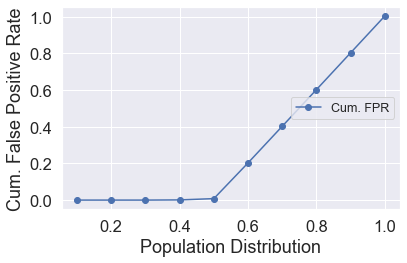

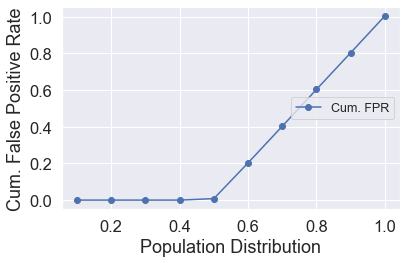

In [127]:
ev.plot_cFPR_Quantile(lt_nn_iterative)
ev.plot_cFPR_Quantile(lt_nn_random)

### Plot NN ROC curve

Random: ROC AUC=0.500
Model: ROC AUC=0.999


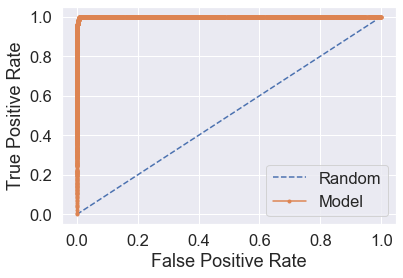

Random: ROC AUC=0.500
Model: ROC AUC=0.999


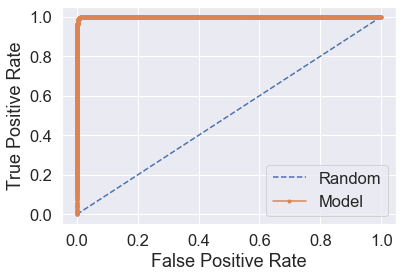

In [128]:
ev.plot_ROC_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='nn_score_iterative', weight_variable=weight_variable_name) 
ev.plot_ROC_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='nn_score_random', weight_variable=weight_variable_name) 

### Plot NN Precision Recall curve

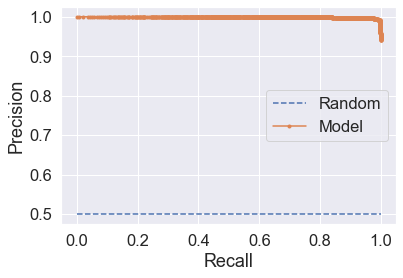

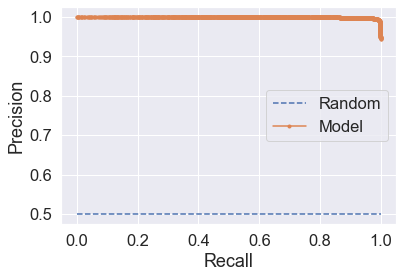

In [129]:
ev.plot_precision_recall_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='nn_score_iterative', 
                            weight_variable=weight_variable_name)
ev.plot_precision_recall_curve(table_name=oos, target_variable=target_variable_name, predicted_variable='nn_score_random', 
                            weight_variable=weight_variable_name)  

### Plot NN F1 score, Accuracy, Sensitivity, Specificity, Precision vs Cutoff

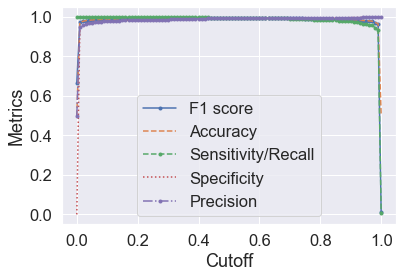

..\functions\evaluation.py:561: RuntimeWarning: invalid value encountered in double_scalars
  model_precision = true_positive/(true_positive+false_positive)


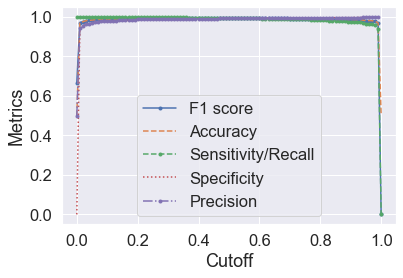

In [130]:
ev.plot_cutoffs(table_name=oos, target_variable=target_variable_name, predicted_variable='nn_score_iterative', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)
ev.plot_cutoffs(table_name=oos, target_variable=target_variable_name, predicted_variable='nn_score_random', 
                            weight_variable=weight_variable_name, n_bands=100, return_table=False)